Warning message in daisy(treatments, metric = "manhattan"):
"binary variable(s) 1, 2, 3, 4, 5, 6, 7, 8 treated as interval scaled"


-Processing clinical data


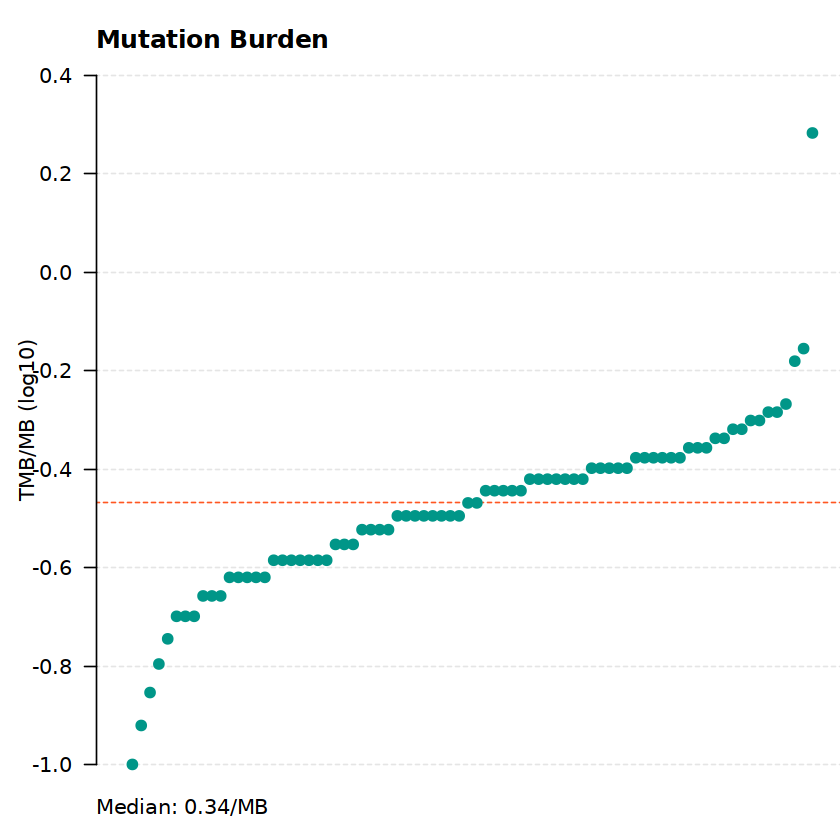

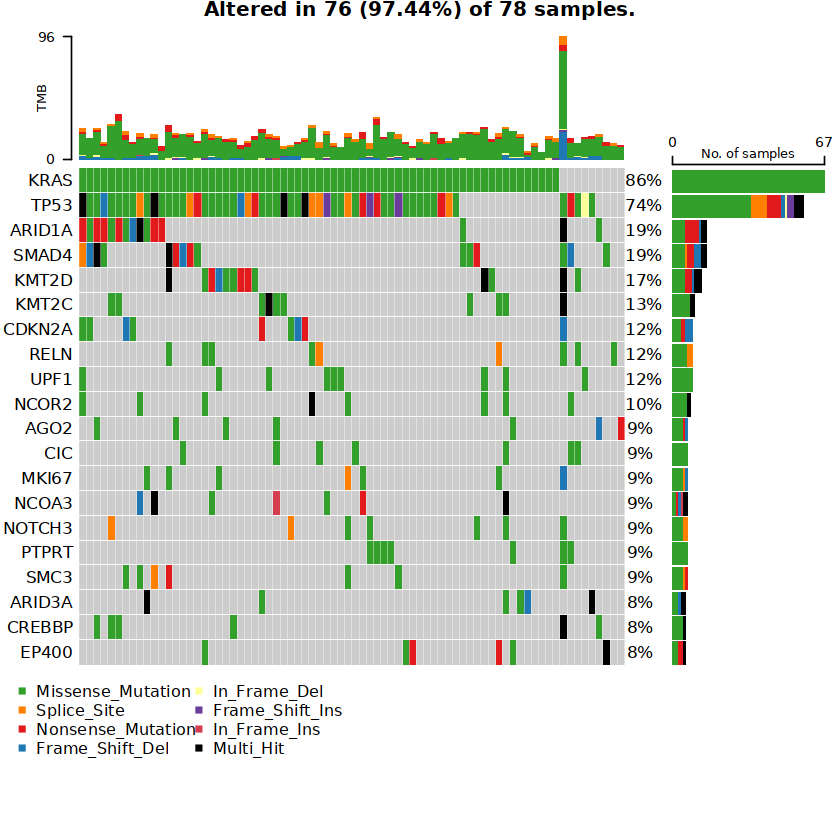

In [1]:
suppressPackageStartupMessages({
    library(ComplexHeatmap)
    library(circlize)
    library(viridis)
    library(matrixStats)
    library(pheatmap)
    library(edgeR)
    library(limma)
    library(tidyverse)
    library(tidyr)
    library(RColorBrewer)
    library(Biobase)
    library(SingleCellExperiment)
    library(readr)
    library(SummarizedExperiment)
    library(zellkonverter)
    library(Seurat)
    library(SeuratDisk)
    library(DESeq2)
    library(ggrepel) 
    library(sva)
    library(tibble)
    library(cluster)
    library(dplyr)
    library(ggplot2)
    library(umap)
    library(patchwork)
    library(knitr)
    library(biomaRt)
    library(ggtext)
    library(org.Hs.eg.db)
    library(AnnotationDbi)
    library(clusterProfiler)
    library(gplots)
    library(gdata)
    library(maftools)
    library(fpc)
    library(reshape2)
    library(gridExtra)
    source('/mnt/beegfs/userdata/d_papakonstantinou/geomx/scripts/geomx_helper_functions.R')
})

group1_color = "#F2CA19"
group2_color = "#E11845"
custom_colors <- c("group1" = group1_color, "group2" = group2_color)

#pdf('/mnt/beegfs/userdata/d_papakonstantinou/rna_seq/rna_seq_analysis.pdf')
############### wes data ################
maf = '/mnt/beegfs/userdata/d_papakonstantinou/wes/pdac_annotated_maf/pdac_filtered.maf' # filtered for driver genes
wes_clinical = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/clinical_11_05_23.csv'

assign_cluster = function(dataframe,columns){
    dataframe <- dataframe[!is.na(dataframe$ICI),]
    rownames(dataframe) <- NULL
    treatments <- as.matrix(dataframe[,columns[-1]])
    dist_matrix <- daisy(treatments, metric = "manhattan")
    hc <- hclust(dist_matrix, method = "ward.D2")
    clusters <- cutree(hc, h = 2)
    dataframe$cluster <- clusters
    dataframe$cluster <- as.character(dataframe$cluster)
    table(dataframe$cluster)
    return(dataframe)
}

get_ontology <- function(genes){
    # Convert gene symbols to Entrez IDs
    entrez_ids <- mapIds(org.Hs.eg.db, 
        keys = genes, 
            keytype = "SYMBOL", 
            column = "ENTREZID")
    # Perform the GO enrichment analysis
    go_enrichment <- enrichGO(gene         = entrez_ids,
        OrgDb        = org.Hs.eg.db,  # Human
        ont          = "ALL",  # Biological process ontology
        pAdjustMethod = "BH", # Benjamini & Hochberg adjustment method
        qvalueCutoff = 0.05)  # q-value cutoff

    # Print the results
    results_length <- nrow(as.data.frame(go_enrichment))
    if (results_length > 0){
        return(as.data.frame(go_enrichment))
    } else {
    return(NULL)
    }
}

treatments <- c("inclusion","Non.alkylating.chemo","Platinum.salts","TKIs","MAPK","PI3K.Akt" ,"DDR","Macrophages","ICI")

pdac.clin <- read.csv(wes_clinical, header = TRUE)
pdac.clin <- assign_cluster(pdac.clin,treatments)

# pdac.clin <- pdac.clin[!is.na(pdac.clin$ICI),]
names(pdac.clin)[names(pdac.clin)=="cluster"] <- "Treatment_Category"
rownames(pdac.clin) <- NULL
pdac.clin$diagnosis_date <- as.Date(pdac.clin$Diagnosis_Date,"%Y/%m/%d")
pdac.clin$dodeath <- as.Date(pdac.clin$dodeath,"%Y-%m-%d")
pdac.clin$Birthdate <- as.Date(pdac.clin$Birthdate,"%Y/%m/%d")
pdac.clin$survival <- as.numeric(difftime(pdac.clin$dodeath,pdac.clin$diagnosis_date))
pdac.clin$age_cat <- ifelse(pdac.clin$Age > 60,"60+","60-")
pdac.clin$Survival_Category <- ifelse(pdac.clin$survival > 1000,"1000+","1000-")
tumor_samples_ids <- unique(pdac.clin$Tumor_Sample_Barcode)
tumor_samples_ids <- tumor_samples_ids[tumor_samples_ids != ""]

pdac = read.maf(
        maf =maf,
        isTCGA = FALSE,
        verbose = FALSE, 
        clinicalData = pdac.clin
        )

pdac <- subsetMaf(pdac ,tsb =tumor_samples_ids) 
maf.data <- pdac@data
maf.data <- maf.data %>%
mutate(t_vaf = t_t_alt_count / (t_t_alt_count + t_t_ref_count))
pdac@data <- maf.data

tmb_df <- maftools::tmb(pdac)
rownames(tmb_df) <-tmb_df$Tumor_Sample_Barcode
oncoplot(maf = pdac, top = 20)

pdac.summary <-  maftools::getSampleSummary(pdac)
#pdac.samples <- pdac.summary$Tumor_Sample_Barcode
pdac_samples <- unique(pdac@data$Tumor_Sample_Barcode)
#cat(paste(pdac.samples,collapse='\n')) print all the samples in the MAF file
kras_pos <- unique(subset(pdac@data,Hugo_Symbol == 'KRAS')$Tumor_Sample_Barcode)
kras_neg <- setdiff(pdac_samples,kras_pos)

tp53_pos <- unique(subset(pdac@data,Hugo_Symbol == 'TP53')$Tumor_Sample_Barcode)
tp53_neg <- setdiff(pdac_samples,tp53_pos)

werba_markers = setNames(list(c( "LGALS4", "CTSE", "TFF1", "AGR2", "TSPAN8", "CEACAM6", "LYZ", "CDH17", "TFF2", "CLDN18", "REG4", "SPINK1", "SLC44A4", "GPX2", "ANXA10", "FAM3D", "TFF3", "MUC13", "ANXA13", "CEACAM5", "VSIG2", "PRSS3", "ALDH2", "IL1R2", "AGR3", "CYSTM1", "CAPN5", "S100A6", "ONECUT2", "BCAS1"),
                            c("KRT6A", "S100A2", "KRT13", "KRT17", "LY6D", "KRT7", "KRT5", "FAM83A", "CD109", "GAPDH", "CSTA", "PTPN13", "MTSS1", "SPRR1B", "SLC2A1", "CAV1", "EMP1", "SEMA3C", "DHRS9", "CAST", "FLNA", "SLITRK6", "COL7A1", "AQP3", "MT2A", "AHNAK2", "KRT19", "PKP1", "YBX3", "GJB5"),
                            c("VCAM1", "MALAT1", "IGFBP3", "SYNE2", "TIMP2", "TNFAIP2", "NFAT5", "SERPINA1", "CXCL14", "CX3CL1", "ALPK3", "PGGHG", "DPYSL2", "TMEM139", "KLF6", "KRT23", "MEGF6", "HOXB2", "PADI1", "MFSD4A", "INPP4B", "BAIAP3", "ARHGAP45", "ECE1", "CAMK2N1", "WFDC2", "TSHZ2", "RILPL2", "LAMB2")),
                            c('Classical','Basal','Intermediate'))

hwang_cnmf_markers = setNames(list(c("PTH2R", "SULT1C2", "ANXA10", "HEPH", "WDR72", "FMO5", "SULT1B1", "SYTL2", "BTNL8", "PLAC8", "STXBP6", "FER1L6", "TM4SF20", "ETNK1", "KCNJ3", "CPS1", "CASR", "THRB", "PIP5K1B", "REG4"), 
                        c("IGF2", "CST6", "CRYAB", "CST4", "FBXO2", "CHPF", "LGALS1", "ALDOA", "MT1E", "ISG15", "CCDC85B", "LY6K", "KRTAP2-3", "MT2A", "CKAP4", "PRNP", "IFI27", "DKK3", "C9orf16", "GJA1"), 
                        c("KRT13", "PSCA", "KRT16", "AC079466.1", "DHRS9", "MUC5AC", "A2ML1", "IFITM10", "FAM83A", "AC019117.2", "KCP", "EPS8L1", "CSNK1E", "PADI1", "PLXNB2", "CDK5RAP3", "NBEAL2", "USP39", "SLC16A3", "TRIM29"), 
                        c("COL1A2", "SPARC", "COL3A1", "LUM", "AEBP1", "COL6A3", "COL1A1", "BGN", "SFRP2", "MMP11", "ACTA2", "FN1", "THBS2", "VIM", "POSTN", "EMILIN1", "DCN", "IGFBP5", "THY1", "DES"), 
                        c("MYL7", "LINC00363", "GCK", "KCNB2", "VWA5B2", "HS6ST3", "CACNA1B", "TMEM196", "RLN1", "GALR1", "IRX2", "KCNAB1-AS1", "RTN1", "RFX6", "MAGEB17", "SLC30A8", "ST18", "KCNK16", "S100Z", "TAT"), 
                        c("KCNJ16", "ZBTB16", "CTNND2", "PDE3A", "PDGFD", "CNTN4", "CFTR", "FLRT2", "ADCY5", "C6", "CRISP3", "RALYL", "NR1H4", "BCL2", "ESRRG", "SLC4A4", "CSMD2", "RGS17", "CRP", "SLC17A4")),
                        c("Classical-like", "Basaloid","Squamoid","Mesenchymal","Neuroendocrine-like","Neural-like progenitor"))
zhang_markers = setNames(list(
                        c("FKBP11", "MZB1", "SSR4", "IGHA1"),
                        c("BANK1", "LY9", "TNFRSF13C", "MS4A1", "CD79A"),
                        c("CD69", "MS4A2", "TPSB2", "CLU"),
                        c("S100A8", "S100A9", "CCL2", "CXCL1", "AIF1", "CD74", "HLA-DRA", "CXCL3", "C1QA", "CXCL2", "APOE", "CD68", "FCER1G"),
                        c("PLVAP", "PECAM1"),
                        c("COL3A1", "ACTA2", "LUM", "COL1A1", "DCN", "COL1A2"),
                        c("PRSS1", "INS", "SST", "CELA2A", "LYZ", "CPA1", "CELA3B", "CELA3A"),
                        c("FXYD2", "LCN2", "CEACAM6", "FXYD3", "EPCAM", "MUC1", "CEACAM5", "KRT19", "AGR2", "TFF2", "TSPAN8","ELF3"),
                        c("MMP7", "TOP2A", "ASPM", "MKI67", "CENPF"),
                        c("FOS", "JUN", "IL7R", "IL2RA", "TRAC"),
                        c("GZMA", "GZMB", "CD3D", "CD3E", "CCL5", "SLC30A1", "GZMH", "NKG7", "KLRD1")),
                        c("Plasma","B cell","Mast cell","Mac/Mono","Endothelial","Fibroblasts","Acinar/Endocrine","Ductal","MKI67+ cell","T cell","NK"))

momac_markers = setNames(list(
                        c("TREM2","APOC1","APOE","SPP1","FABP5","LGALS3","CD9","LIPA"),
                        c("HES1","C1QA","C1QB","C1QC","CCL3","CCL4","HBEGF","APOE","LIPA","CCL18"),
                        c("IL4I1","IDO1","CXCL9","CXCL10","CXCL11","CD40","CCL8","LAMP3"),
                        c("RGS1",'HLA-DRB1','HLA-DPB1'),
                        c('VEGFA','CCL20','IL1RN','CXCL2','CXCL3','EREG','PLAUR','CCL4','TNFAIP3','CD44'),
                        c('FCER1A','CLEC10A','CD1C','CD1E','CD74'),
                        c('C1Q','C1QA','C1QB','C1QB','C1QC','HLA-DRB1'),
                        c('STMN1','TUBB','TOP2A','HMGB2','CDK1','MKI67'),
                        c('S100A8','S100A9','S100A12','VCAN','S100A6','FOS','LYZ','HMGB2','KLF6')),
                        c("TREM2", "HES1", "IL4I1", "RGS1", "IL1B", "DC2/3", "C1Q",'STMN1', 'S100A8'))

group1 = c("M2683", "M2644", "M578", "M2640", "M2650", "M844", "M2653", "M1121", "M077", "M2755", "M573", "M2686", "M2651", "M2725", "M2759", "M492", "M2687", "M2669", "MR695", "MR684", "M2086", "M2700", "MR836", "MR776", "MR702", "M2721", "M351", "M172", "M2715", "MR848", "M194")
group2 = c("M2666", "M2723", "M2746", "M157", "M2711", "M2753", "M2716", "M2760", "M2701", "M2747", "MR1096", "M2695", "M2738", "M167", "MR777", "M2681", "M2647", "M2671", "MR656", "M386", "M2722", "M2730", "M2713", "M2658", "M2703", "M2560", "M523", "M2494", "MR909", "M2708", "M2271", "M2761", "M2330", "M2312", "M2745", "M672", "M494", "M2733", "M2729", "M2754", "M2677", "M2758", "M2416", "MR513", "M2756", "M2709", "M2654", "M2710")
# colnames(pdac.clin)
# nrow(pdac.clin)
# table(pdac.clin$Diagnosis)

# CLINICAL

In [2]:
#################### CLINICAL ##########################
options(warn=-1)
clinical = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/clinical_06_10_23.csv'
clinical <- read.csv(clinical, header = TRUE)
#clinical <- assign_cluster(clinical,cols)
clinical <- clinical[!is.na(clinical$ICI),]
clinical$diagnosis_date <- as.Date(clinical$Diagnosis_Date,"%Y/%m/%d")
clinical$dodeath <- as.Date(clinical$dodeath,"%Y-%m-%d")
clinical$Birthdate <- as.Date(clinical$Birthdate,"%Y/%m/%d")
clinical$survival <- interval(clinical$diagnosis_date, clinical$dodeath) %/% days(1)
clinical$tumor_age <- interval(clinical$Diagnosis_Date, clinical$Biopsie_Date) %/% months(1)
clinical$age_cat <- ifelse(clinical$Age > 60,"60+","60-")

# add metadata orgasation and technical platform
metadata = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/dataset.MyeloidDiversity.metadata_20230621164433.csv'
metadata <- read.csv(metadata, header = TRUE,sep=';')
metadata <- subset(metadata,protocol == 'mRNA-seq')
metadata$Alias.NOIGR <- as.numeric(gsub("[^0-9]", "", metadata$Alias.NOIGR))
metadata <- unique(metadata[,c("organisation","technicalPlatform","Alias.NOIGR")])

clinical$NIP <- as.numeric(gsub("[^0-9]", "", clinical$NIP))





merged <- merge(clinical,metadata ,by.x='NIP',by.y='Alias.NOIGR',all.x = T,all.y=F)
clinical$organisation <- merged$organisation
clinical$technicalPlatform <- merged$technicalPlatform
names(clinical)[names(clinical)=="RNA"] <- "rna"
clinical <- clinical[order(as.Date(clinical$Biopsie_Date, format="%Y/%m/%d")),]
rownames(clinical) <- clinical$inclusion
clinical$kras <- ifelse(clinical$Tumor_Sample_Barcode %in% kras_pos,"kras_pos",ifelse(clinical$Tumor_Sample_Barcode %in% kras_neg,"kras_neg","unknown"))
clinical$tp53 <- ifelse(clinical$Tumor_Sample_Barcode %in% tp53_pos,"tp53_pos",ifelse(clinical$Tumor_Sample_Barcode %in% tp53_neg,"tp53_neg","unknown"))

clinical$Group <- NA
clinical$Group[rownames(clinical) %in% group1] <- "Group1"
clinical$Group[rownames(clinical) %in% group2] <- "Group2"

calculate_cramers_v <- function(df, cat_col, group_col) {
  # Create contingency table
  df[[cat_col]][is.na(df[[cat_col]])] <- "unknown"
  cont_table <- table(df[[cat_col]], df[[group_col]])
  
  # Perform chi-square test
  chi_sq_test <- chisq.test(cont_table)
  
  # Calculate Cramér's V
  n <- sum(cont_table)
  min_dim <- min(nrow(cont_table) - 1, ncol(cont_table) - 1)
  cramers_v <- sqrt(chi_sq_test$statistic / (n * min_dim))
  
  return(cramers_v)
}
# Identify categorical columns (factors or characters)
categorical_cols <- sapply(clinical, function(x) is.factor(x) | is.character(x))
categorical_col_names <- names(clinical)[categorical_cols]
#print(categorical_col_names)                           
#cat_columns <- c("kras", "tp53")
results <- sapply(categorical_col_names, function(col) calculate_cramers_v(clinical, col, "Group"))

result_df <- data.frame(
  Category = categorical_col_names,
  Cramers_V = results,
  row.names = NULL
)
kable(head(result_df[order(result_df$Cramers_V,decreasing=T),],10))

clinical$TMB <- tmb_df$total[match(clinical$Tumor_Sample_Barcode, tmb_df$Tumor_Sample_Barcode)]
# Assuming your dataframes are called df1 and df2
fill_mutation_matrix <- function(df1, df2, genes) {
    # Create columns for genes if they don't exist
    for(gene in genes) {
        if(!(gene %in% colnames(df1))) {
            df1[[gene]] <- NA
        }
    }
    
    # For each row in df1
    for(i in 1:nrow(df1)) {
        # Get current tumor sample
        current_sample <- df1$Tumor_Sample_Barcode[i]
        # Find all mutations for this sample in df2
        sample_mutations <- df2[df2$Tumor_Sample_Barcode == current_sample, ]
        # For each gene we're interested in
        for(gene in genes) {
            # Find if there's a mutation for this gene
            mutation_idx <- which(sample_mutations$Hugo_Symbol == gene)
            # If we found a mutation, fill it in
            if(length(mutation_idx) > 0) {
                df1[i, gene] <- as.character(sample_mutations$Variant_Type[mutation_idx[1]])
                
            } else {df1[i, gene] <- "NA"}
        }
    }
    return(df1)
}
top_mutated_genes <- c("KRAS", "TP53", "ARID1A", "SMAD4", "KMT2D", "KMT2C", "CDKN2A", "RELN", "UPF1", "NCOR2", "AGO2")
clinical <- fill_mutation_matrix(clinical,maf.data[,c("Tumor_Sample_Barcode",'Hugo_Symbol','Variant_Type')],top_mutated_genes)
nrow(clinical)                  
colnames(clinical)
head(clinical[,c('NIP','inclusion','WES_normal','WES_tumor','rna')])
table(clinical$Biopsy.time)                  
table(clinical$meta.site.histo)           
table(clinical$Primitif)           
table(clinical$Meta)
table(clinical$Biopsy_Site)
sum(!is.na(clinical$TMB))

print(intersect(clinical$NIP,metadata$Alias.NOIGR))



|   |Category        | Cramers_V|
|:--|:---------------|---------:|
|16 |scRNA           |       Inf|
|39 |Group           | 1.0000000|
|30 |batch3          | 0.6753914|
|33 |Biopsy_Site     | 0.4050565|
|25 |site.biopsie    | 0.3784299|
|27 |meta.site.histo | 0.3446614|
|10 |Diabetes        | 0.2783237|
|23 |batch1          | 0.2703423|
|3  |Panel           | 0.2665621|
|24 |batch2          | 0.2281675|

[1] 95

[1] "X"                       "Unnamed..0"             
 [3] "Record.ID"               "NIP"                    
 [5] "inclusion"               "numeric_inclusion"      
 [7] "Tumor_Sample_Barcode"    "Panel"                  
 [9] "Sex"                     "Birthdate"              
[11] "Age"                     "dodeath"                
[13] "Is_dead"                 "Weight"                 
[15] "Height_cm"               "Cause_of_Death"         
[17] "Thrombose"               "Alcool"                 
[19] "Smoking"                 "Diabetes"               
[21] "Tumor_dim_mm"            "Diagnosis_Date"         
[23] "Biopsie_Date"            "WES_normal"             
[25] "WES_tumor"               "rna"                    
[27] "scRNA"                   "Diagnosis"              
[29] "Biopsy.time"             "Non.alkylating.chemo"   
[31] "Platinum.salts"          "TKIs"                   
[33] "MAPK"                    "PI3K.Akt"               
[35] "DDR"                     "Macrophages"            
[37] "ICI"                     "Biopsie_tissue"         
[39] "cellularity"             "autre_cassete_dispo.20."
[41] "arn_restant"             "batch1"                 
[43] "batch2"                  "site.biopsie"           
[45] "Meta"                    "meta.site.histo"        
[47] "Primitif"                "biopsie"                
[49] "batch3"                  "batch3_group"           
[51] "age"                     "cnv_cluster"            
[53] "Biopsy_Site"             "diagnosis_date"         
[55] "survival"                "tumor_age"              
[57] "age_cat"                 "organisation"           
[59] "technicalPlatform"       "kras"                   
[61] "tp53"                    "Group"                  
[63] "TMB"                     "KRAS"                   
[65] "TP53"                    "ARID1A"                 
[67] "SMAD4"                   "KMT2D"                  
[69] "KMT2C"                   "CDKN2A"                 
[71] "RELN"                    "UPF1"                   
[73] "NCOR2"                   "AGO2"

NIP       inclusion WES_normal WES_tumor rna
M077 201202855 M077      YES        YES       YES
M108 201205917 M108      YES        NO        NO 
M107 201204705 M107      YES        NO        NO 
M157 201211315 M157      YES        YES       YES
M167 201110258 M167      YES        YES       YES
M172 201202875 M172      YES        YES       YES


post-Tx  pre-Tx 
     91       4 


                                     foie             ganglion 
                  35                   45                    4 
              poumon p\357\277\275ritoine 
                   8                    3 


    YES  no 
 30   7  58 


    YES  no 
 29  60   6 


                               foie          ganglion ganglion cervical 
                9                62                 1                 1 
    ganglionnaire                os            poumon          primitif 
                1                 1                12                 3 
 p\303\251ritoine              sang 
                3                 2 

[1] 78

 [1] 201202855 201211315 201110258 201202875 201117577 201311050 201312539
 [8] 201316001 201400922 201405643 201206679 201406008 201410225 201414157
[15] 201515544 198706786 201700448 201307822 201701800 201710058 201713411
[22] 199410386 201808114 201906585 201908373 201908562 201816867 201909732
[29] 201910058 201808836 201908665 201910903 201910887 201811269 201913193
[36] 201911458 200916228 201911488 201912254 201810045 201814750 201808487
[43] 201813762 201914577 201901702 201916652 201208220 201610619 201810111
[50] 201914569 201910974 201918029 201908761 201920567 201804837 202001841
[57] 202000784 202001378 202000279 201501330 202007821 201916040 202012278
[64] 202001858 201907673 202005036 202011397 202009733 201701508 202017945
[71] 202100263 202100435 201903040 202013914 202011994 202020451 202102528
[78] 198601614 201506745 202110195


# Piecharts

[1] "X"                       "Unnamed..0"             
 [3] "Record.ID"               "NIP"                    
 [5] "inclusion"               "numeric_inclusion"      
 [7] "Tumor_Sample_Barcode"    "Panel"                  
 [9] "Sex"                     "Birthdate"              
[11] "Age"                     "dodeath"                
[13] "Is_dead"                 "Weight"                 
[15] "Height_cm"               "Cause_of_Death"         
[17] "Thrombose"               "Alcool"                 
[19] "Smoking"                 "Diabetes"               
[21] "Tumor_dim_mm"            "Diagnosis_Date"         
[23] "Biopsie_Date"            "WES_normal"             
[25] "WES_tumor"               "rna"                    
[27] "scRNA"                   "Diagnosis"              
[29] "Biopsy.time"             "Non.alkylating.chemo"   
[31] "Platinum.salts"          "TKIs"                   
[33] "MAPK"                    "PI3K.Akt"               
[35] "DDR"                     "Macrophages"            
[37] "ICI"                     "Biopsie_tissue"         
[39] "cellularity"             "autre_cassete_dispo.20."
[41] "arn_restant"             "batch1"                 
[43] "batch2"                  "site.biopsie"           
[45] "Meta"                    "meta.site.histo"        
[47] "Primitif"                "biopsie"                
[49] "batch3"                  "batch3_group"           
[51] "age"                     "cnv_cluster"            
[53] "Biopsy_Site"             "diagnosis_date"         
[55] "survival"                "tumor_age"              
[57] "age_cat"                 "organisation"           
[59] "technicalPlatform"       "kras"                   
[61] "tp53"                    "Group"                  
[63] "TMB"                     "KRAS"                   
[65] "TP53"                    "ARID1A"                 
[67] "SMAD4"                   "KMT2D"                  
[69] "KMT2C"                   "CDKN2A"                 
[71] "RELN"                    "UPF1"                   
[73] "NCOR2"                   "AGO2"

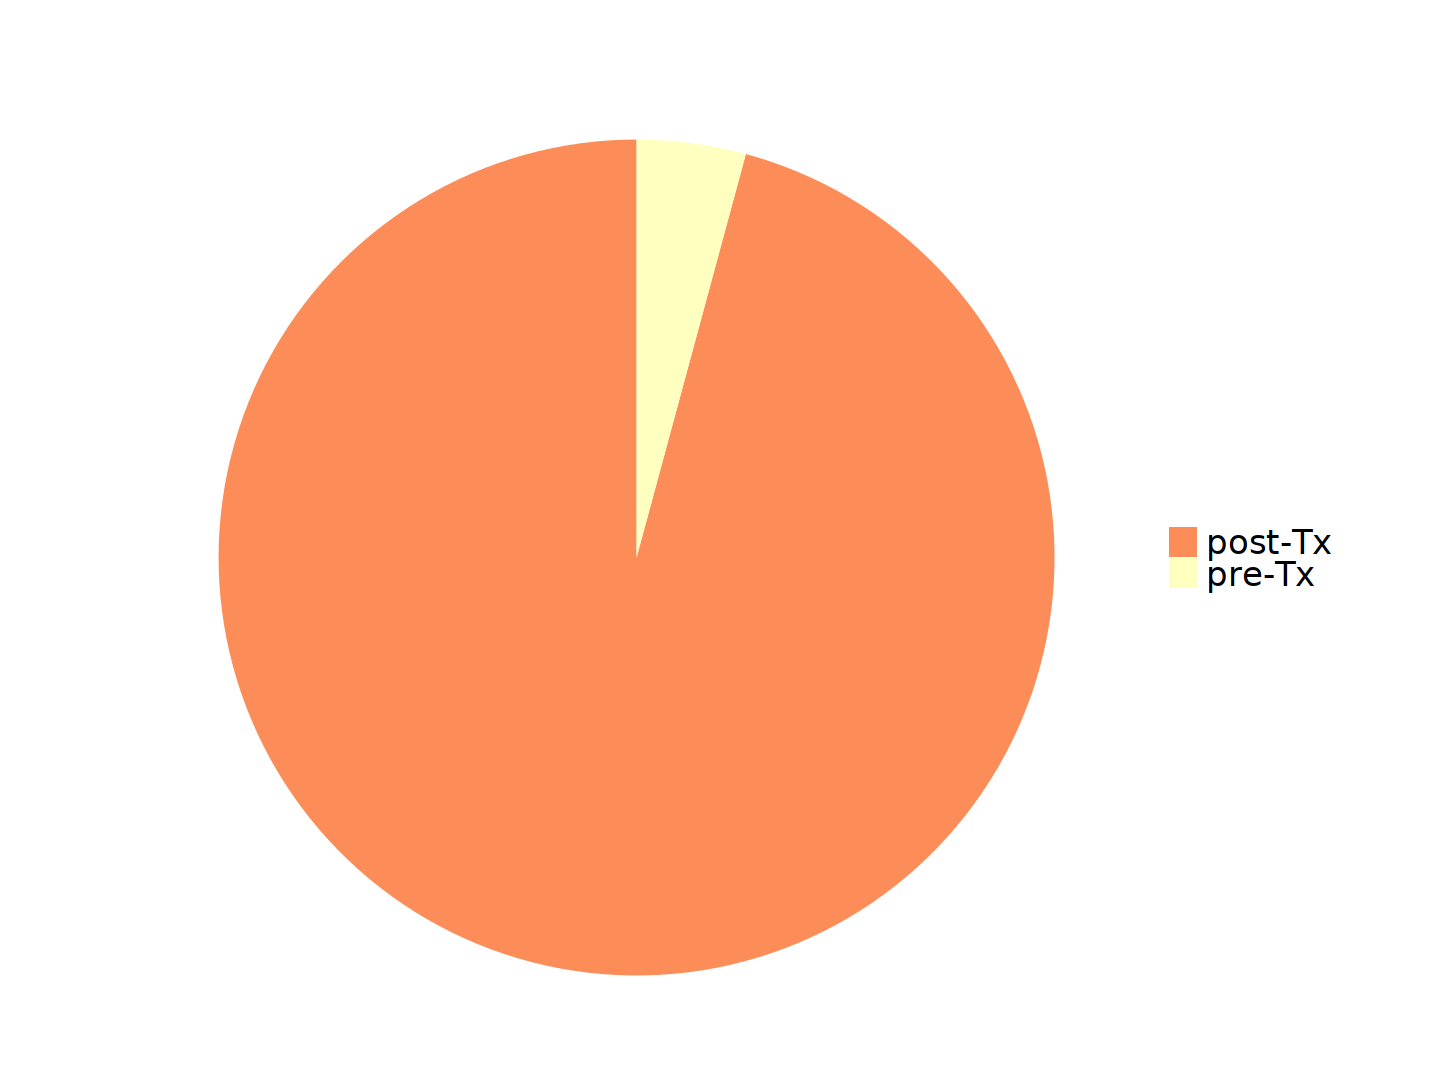

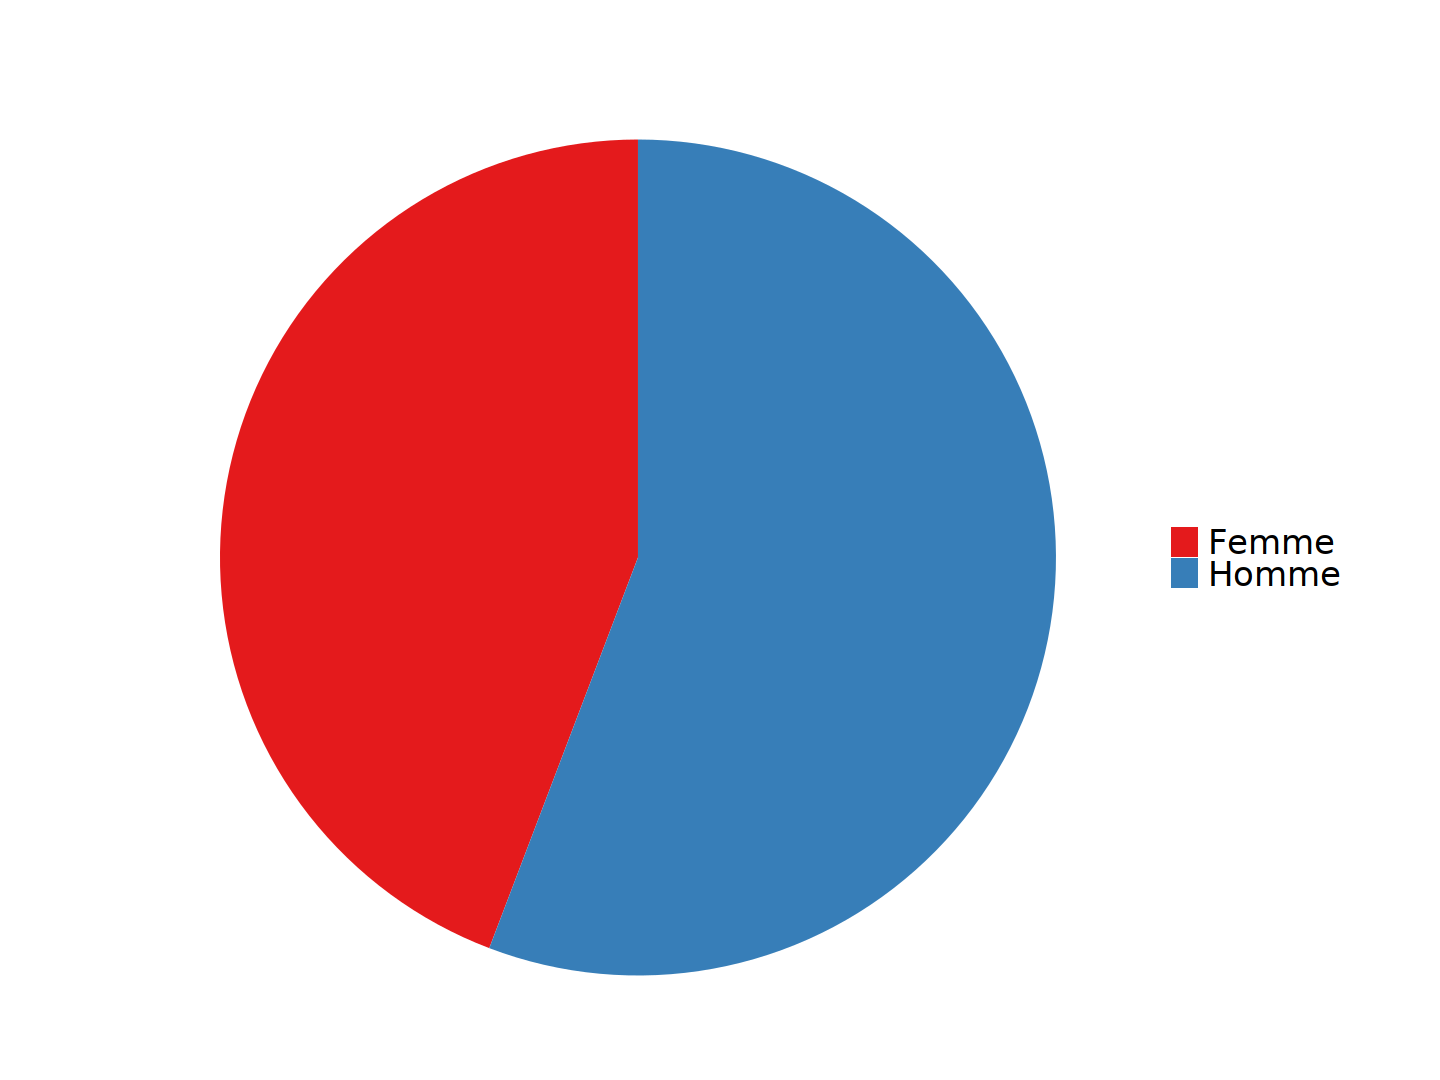

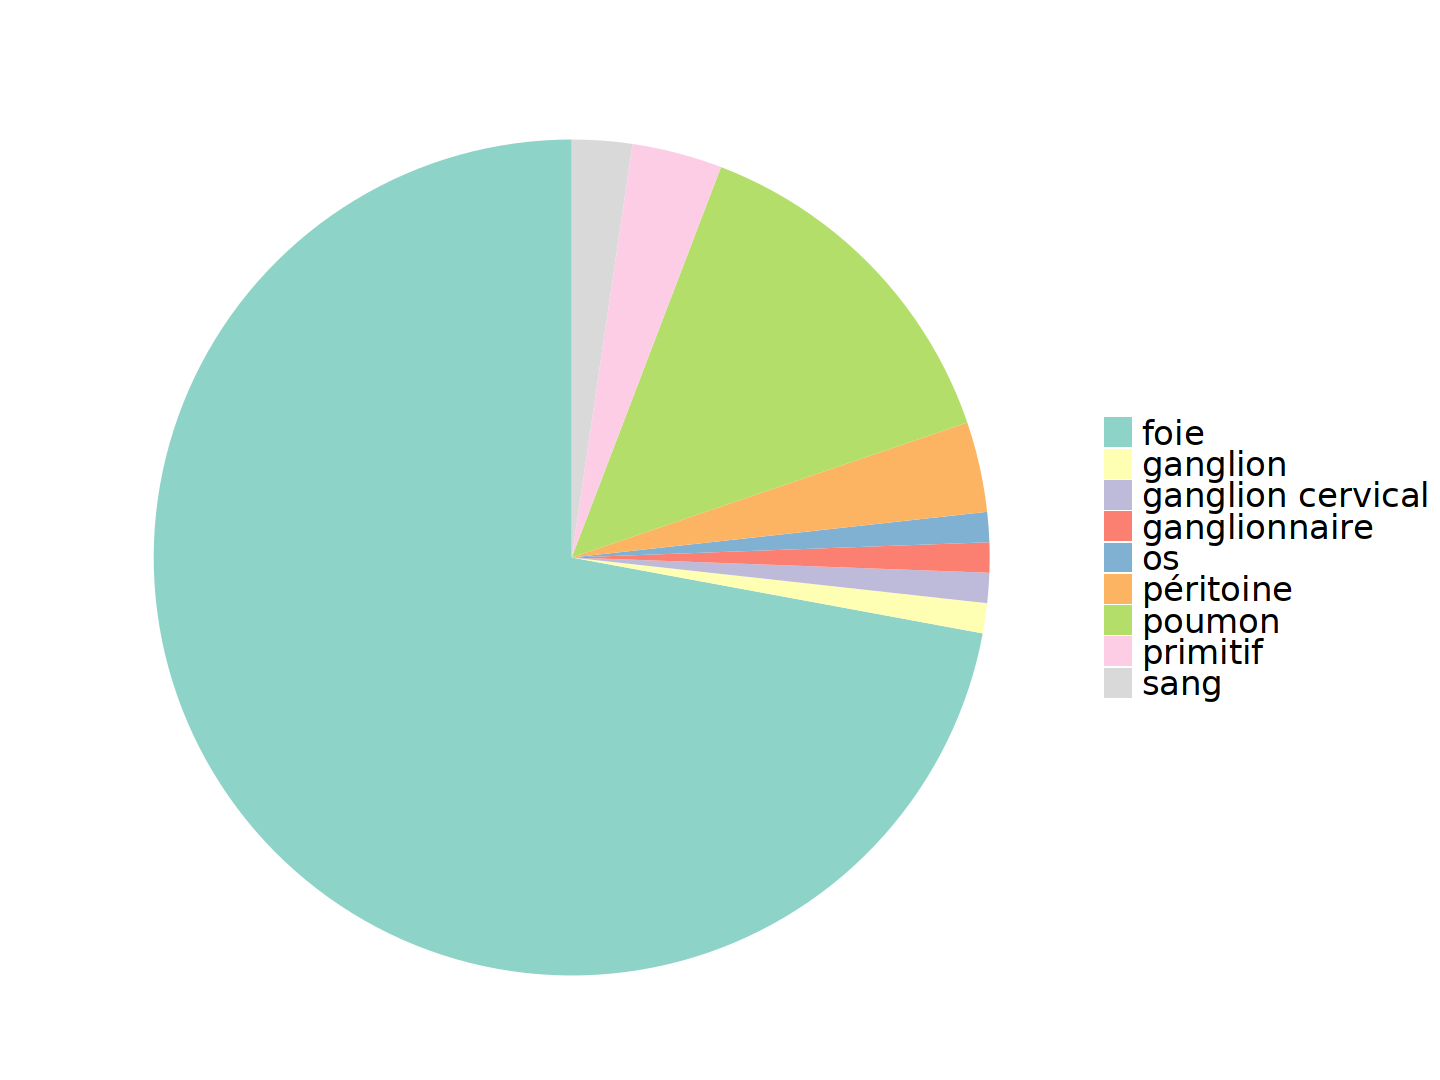

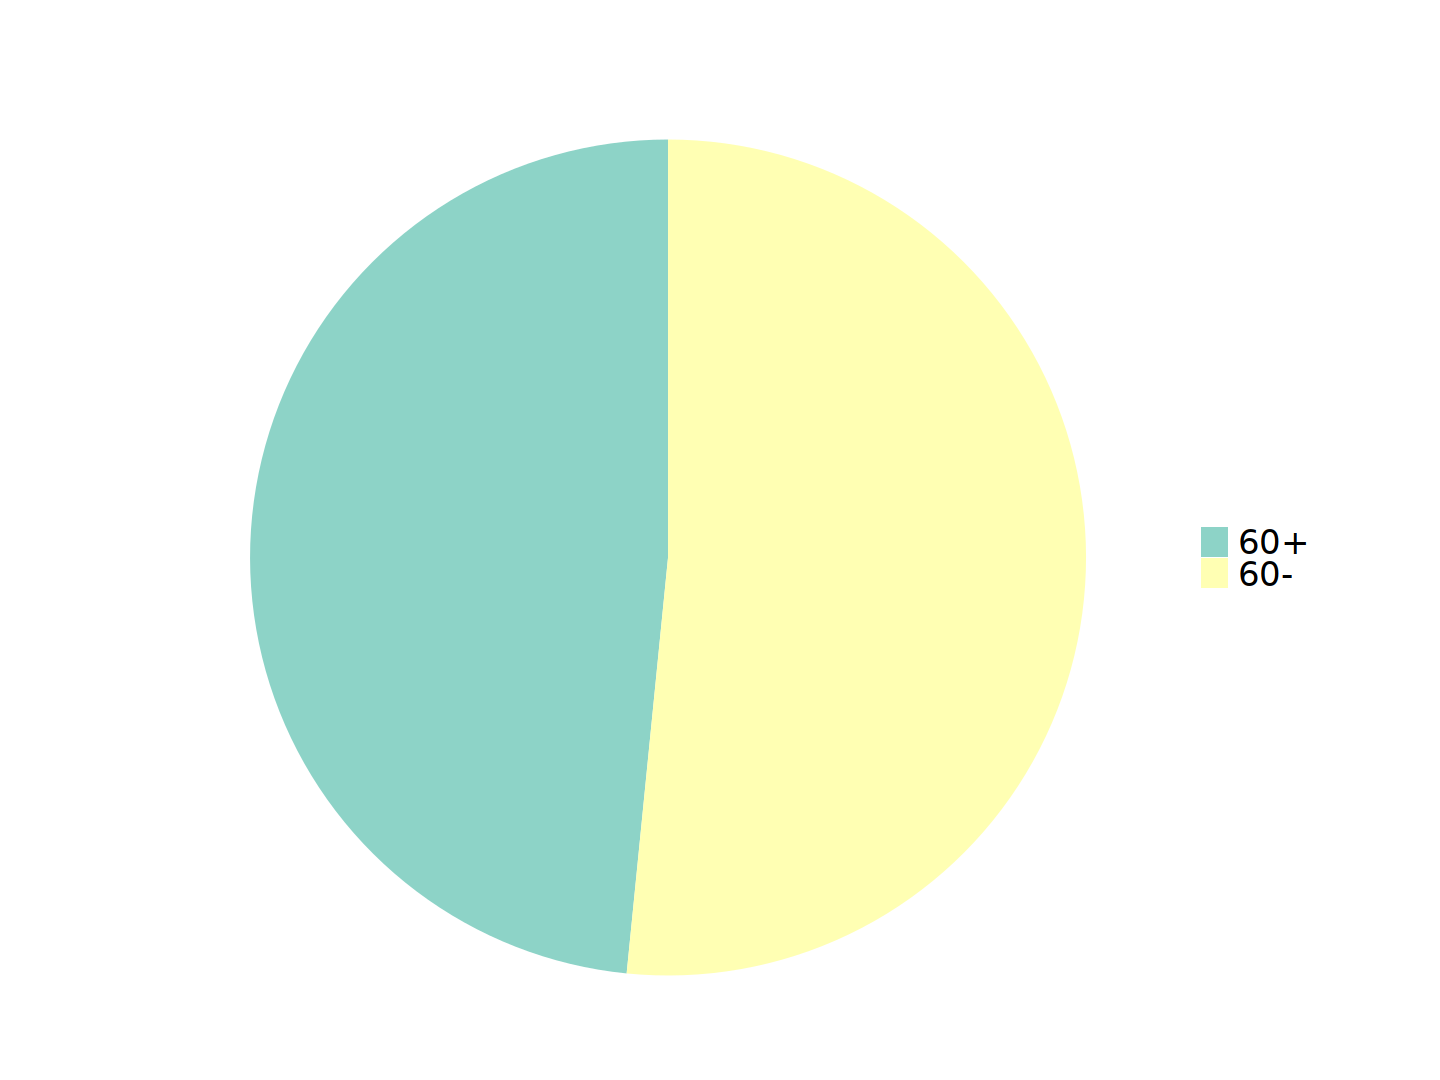

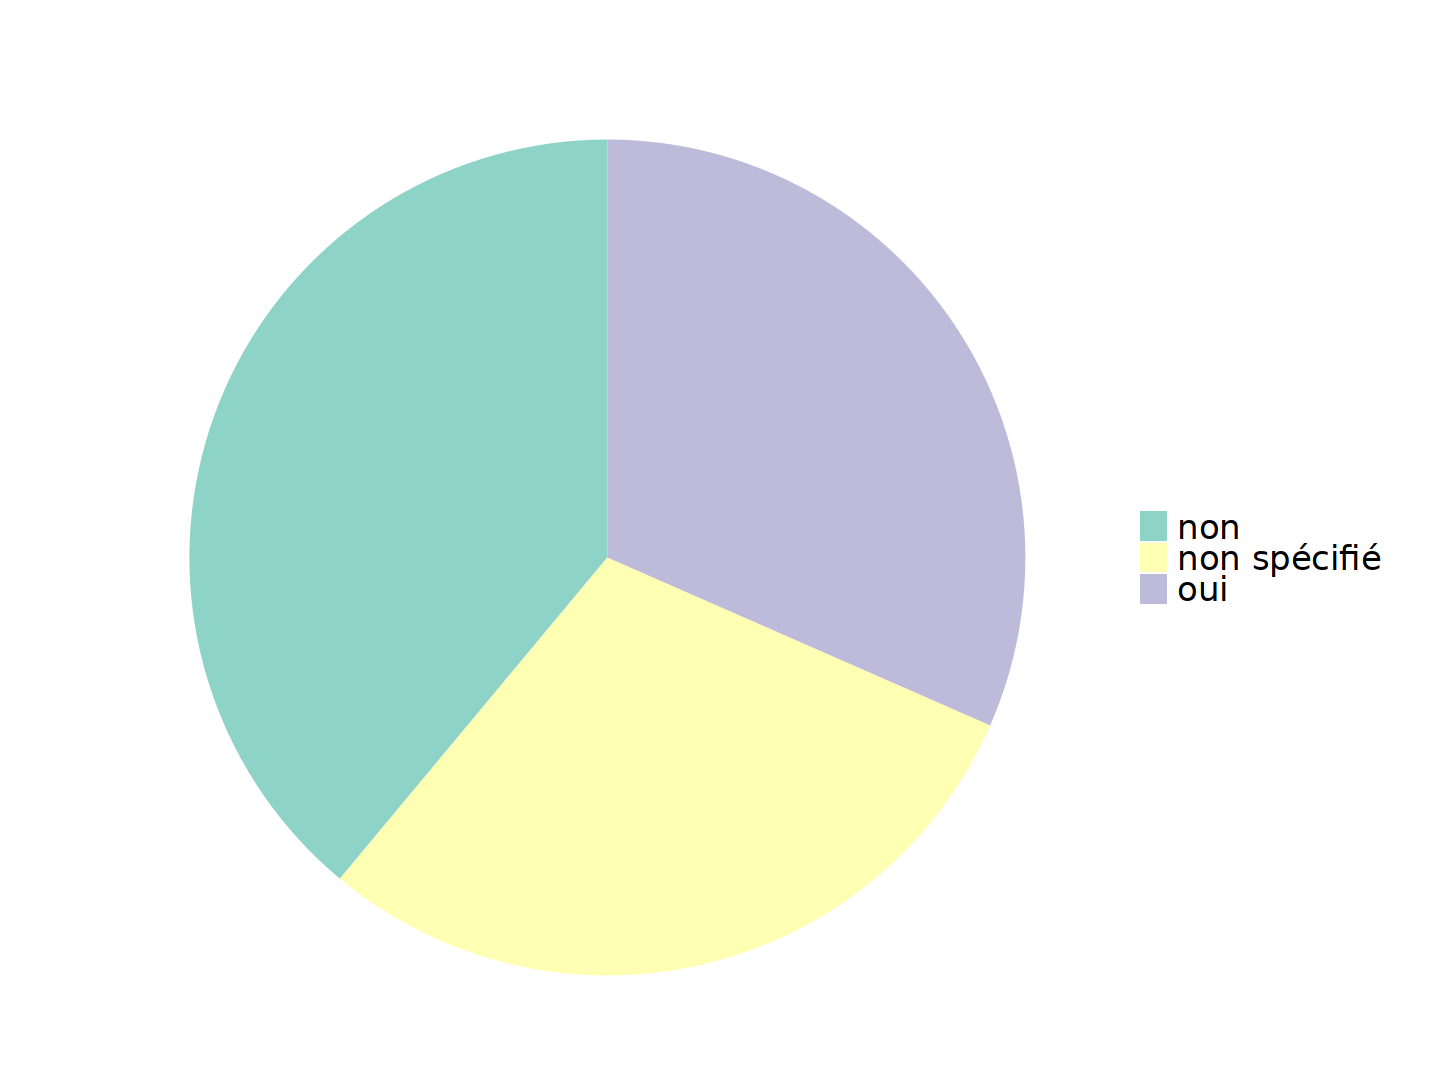


post-Tx  pre-Tx 
     91       4 


Femme Homme 
   42    53 


                               foie          ganglion ganglion cervical 
                9                62                 1                 1 
    ganglionnaire                os  p<U+00E9>ritoine            poumon 
                1                 1                 3                12 
         primitif              sang 
                3                 2 

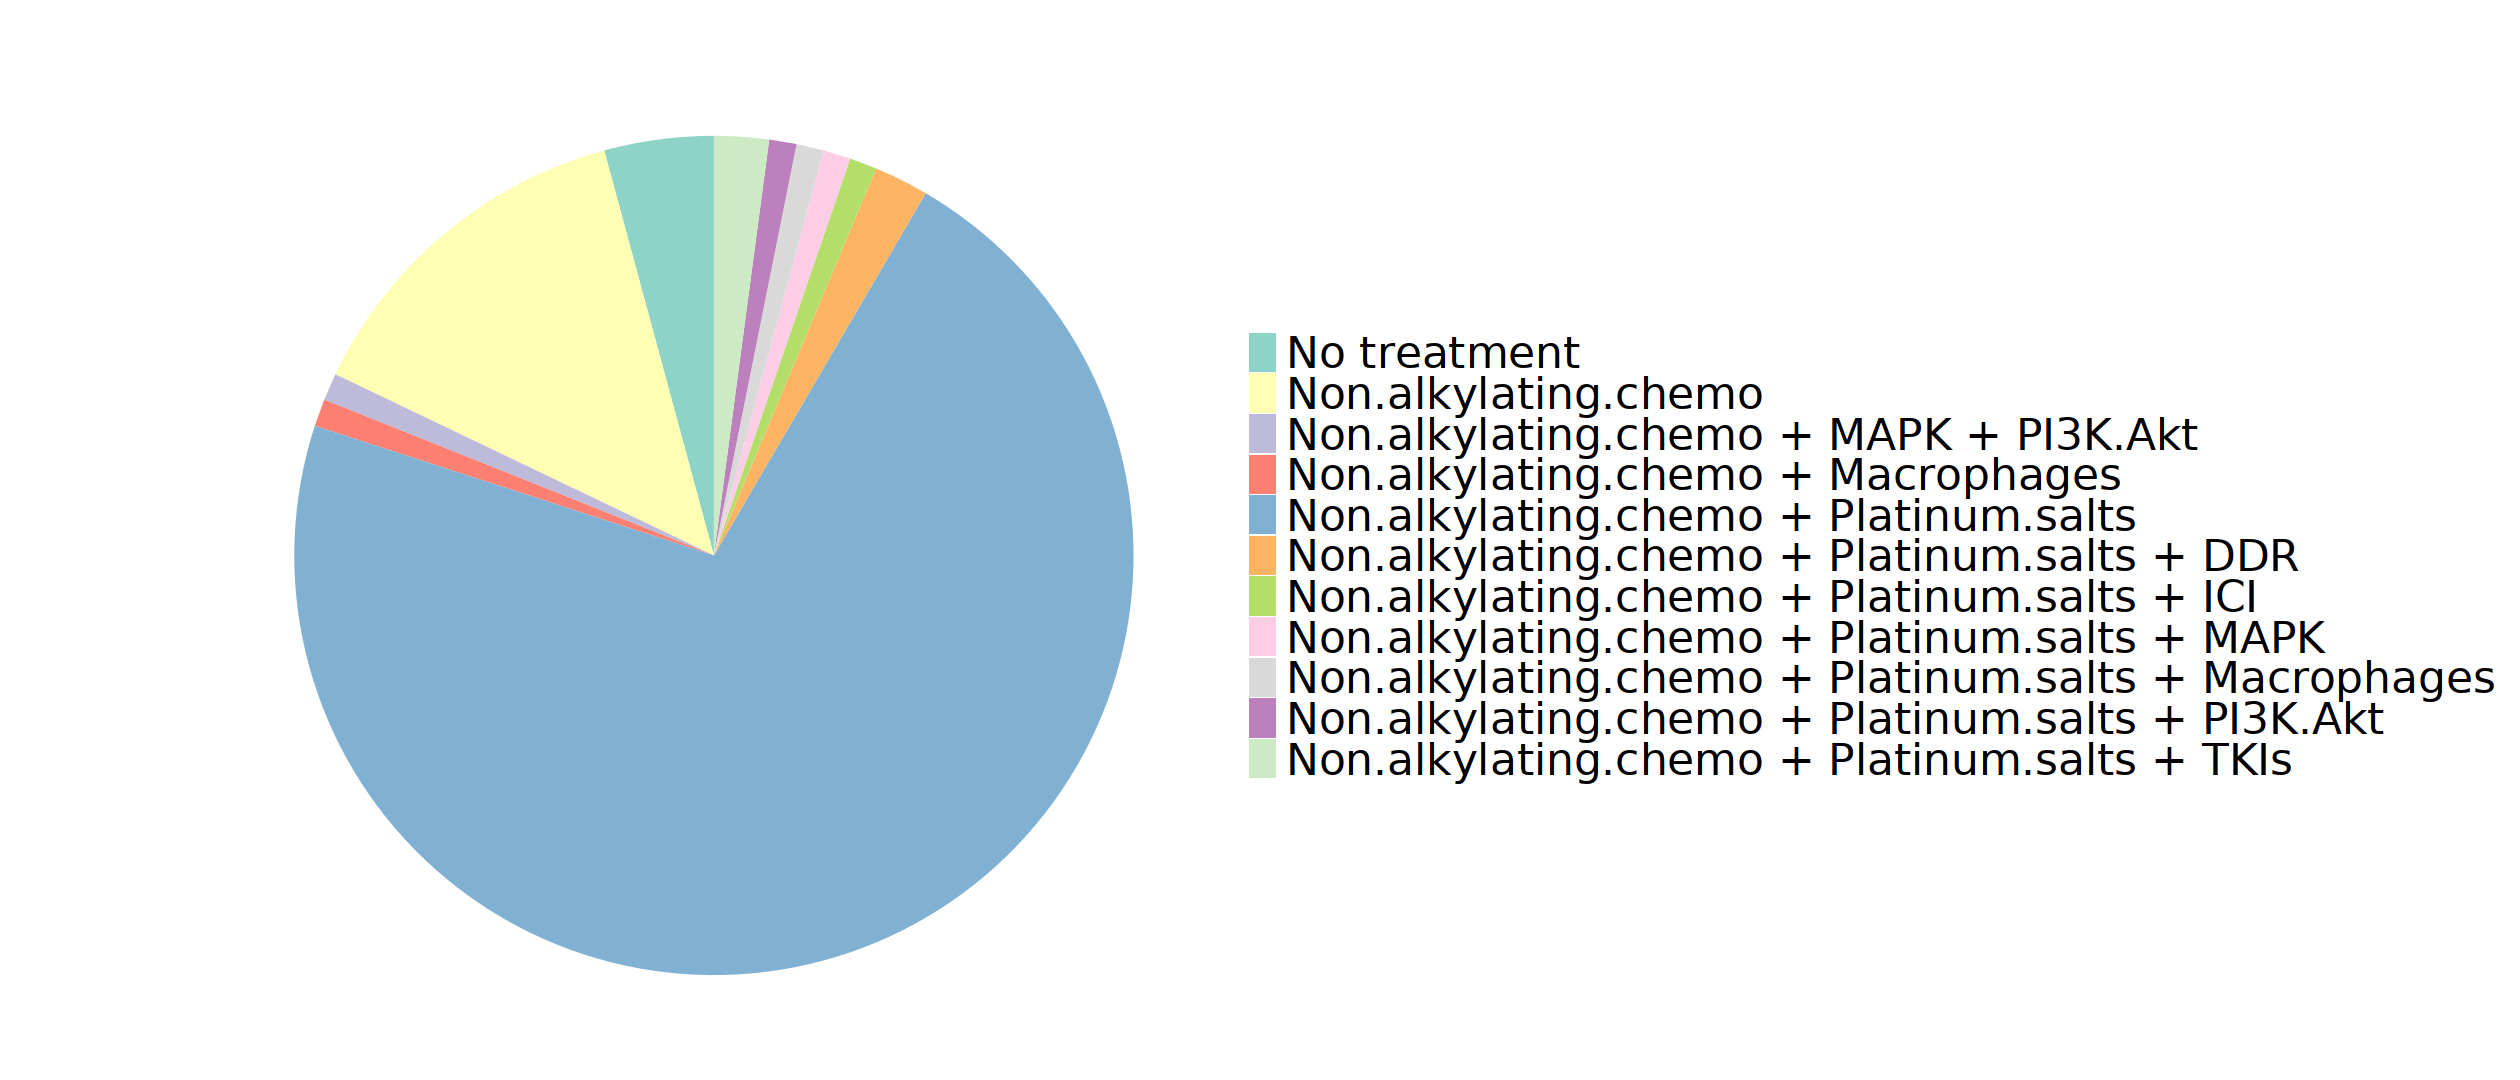

In [3]:
library(ggplot2)
library(tidyverse)

make_pie_chart <- function(df, cat_col,title, palette = "Set1") {
  # Get counts of each category
  category_counts <- table(df[[cat_col]])
  
  # Create the pie chart data
  pie_data <- data.frame(
    category = names(category_counts),
    count = as.numeric(category_counts)
  )
  
  # Create the pie chart
  ggplot(pie_data, aes(x = "", y = count, fill = category)) +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    scale_fill_brewer(palette = palette) +
    theme_void() +
    theme(
      plot.title = element_text(size = 16, face = "bold"),
      axis.title = element_blank(),
      axis.text = element_blank(),
      legend.title = element_blank(),
      legend.text = element_text(size = 20),
        base_family = "DejaVu Sans"
    ) +
    labs(title = paste(title),
         fill = cat_col)
}

get_treatment_combo <- function(row) {
  treatments <- names(row)[row == 1]
  if (length(treatments) == 0) return("No treatment")
  paste(treatments, collapse = " + ")
}

treatment_analysis <- function(df) {
  # Get combinations and ensure it's a character vector
  combinations <- as.character(apply(df, 1, get_treatment_combo))
  
  # Create summary dataframe
  summary_df <- data.frame(combination = combinations, stringsAsFactors = FALSE) %>%
    group_by(combination) %>%
    summarise(count = n()) %>%
    mutate(
      percentage = round(count / sum(count) * 100, 1),
      label = paste0(combination, "\n(", percentage, "%)"),
      # Calculate the position of labels
      position = cumsum(count) - count / 2
    ) %>%
    ungroup()
  
  # Create pie chart using ggplot2
  p <- ggplot(summary_df, aes(x = "", y = count, fill = combination)) +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    scale_fill_brewer(palette = 'Set3') +
  theme_void() +
  theme(
   legend.title = element_blank(),  # Removes the legend title
    legend.text = element_text(size = 26)  # Adjust legend text size if needed
  ) +
  labs(title = '')  # Keep the main plot title empty if desired
  
  print(p)
  
  # Return the summary dataframe
  return(summary_df)
}
library(stringi)

clinical$Biopsy_Site <- stri_unescape_unicode(clinical$Biopsy_Site)
clinical$Smoking <- stri_unescape_unicode(clinical$Smoking)

options(repr.plot.width=12, repr.plot.height=9)
colnames(clinical)
make_pie_chart(clinical,'Biopsy.time','','Spectral')
make_pie_chart(clinical,'Sex','','Set1')
make_pie_chart(clinical[clinical$Biopsy_Site !=  "" ,],'Biopsy_Site','','Set3')
make_pie_chart(clinical,'age_cat','','Set3')
make_pie_chart(clinical,'Smoking','','Set3')
options(repr.plot.width=21, repr.plot.height=9)
df <- clinical[, c('Non.alkylating.chemo', 'Platinum.salts', 'TKIs', 'MAPK', 'PI3K.Akt', 'DDR', 'Macrophages', 'ICI')]
result <- treatment_analysis(df)
table(clinical$Biopsy.time)
table(clinical$Sex)
table(clinical$Biopsy_Site)

# Count Matrix

In [4]:
############### load count matrix from file ###############
load('/mnt/beegfs/userdata/d_papakonstantinou/rna_seq/raw_counts.RData') #raw count matrix
###########################################################

cols <- colnames(count_matrix)
new_cols <- c()
for (col in cols) {
        if (grepl('A',col,fixed = TRUE)){
                if (grepl('MR',col,fixed = TRUE)){
                        new_col <- gsub('A','',col)
                        colnames(count_matrix)[colnames(count_matrix) == col] <- new_col
                } else {
                        new_col <- gsub('A','MR',col)
                        colnames(count_matrix)[colnames(count_matrix) == col] <- new_col
                }
        }
}

common <- intersect(clinical$inclusion,colnames(count_matrix))
clinical <- filter(clinical,inclusion %in% common)
count_matrix <- count_matrix[,common]
library_sizes <- colSums(count_matrix)
clinical$library_size <- library_sizes[rownames(clinical)]
######################################################

# Umap

Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 79
Number of edges: 2520

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5345
Number of communities: 2
Elapsed time: 0 seconds


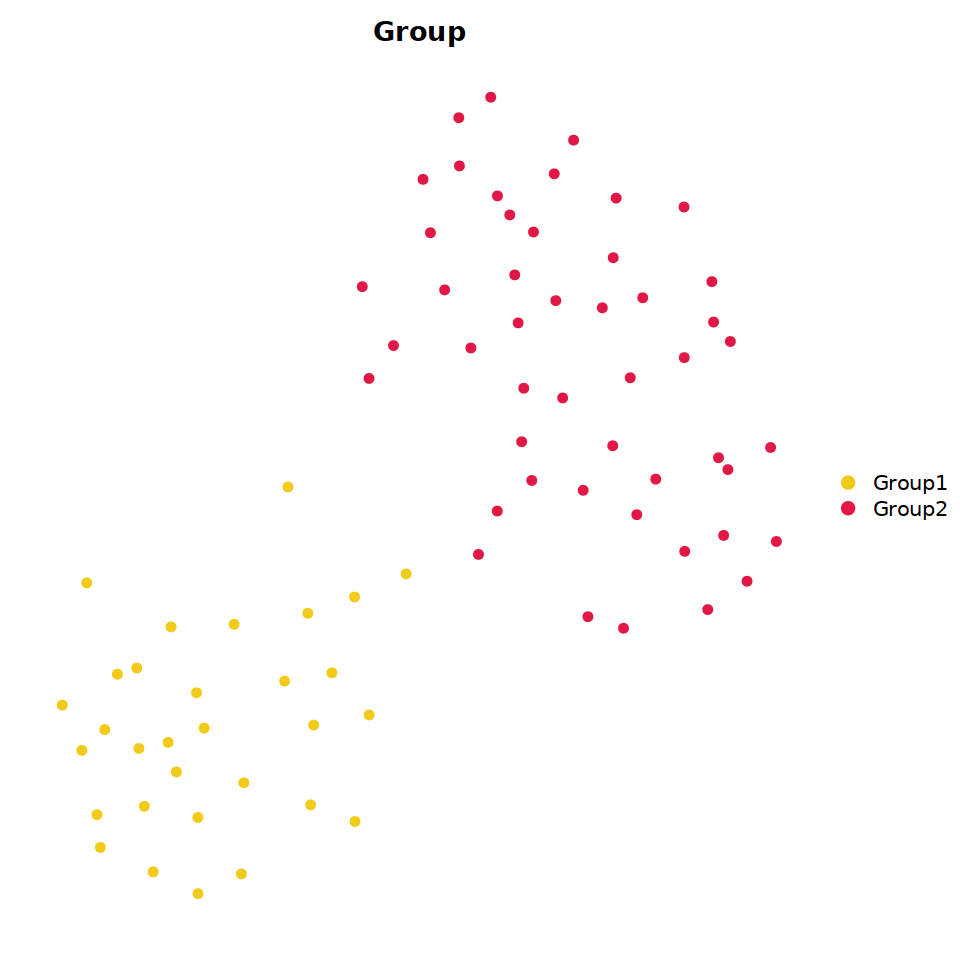

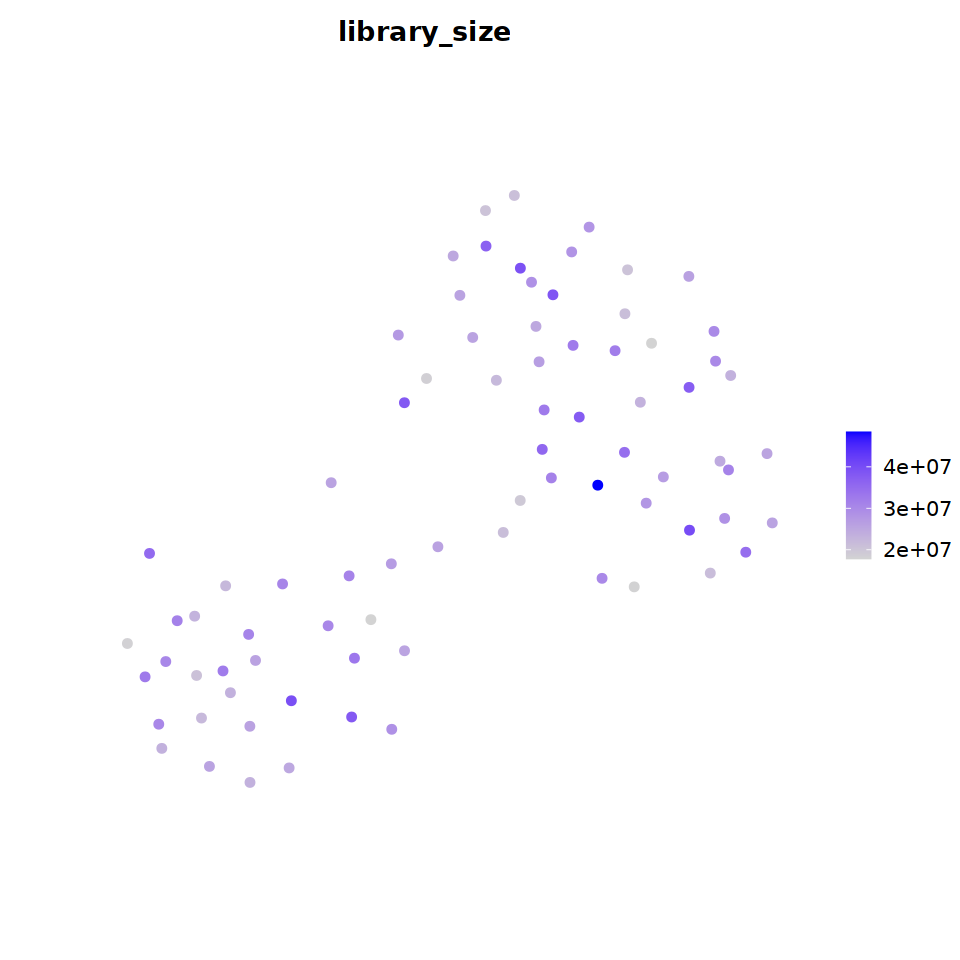

In [5]:
rownames(clinical) <- clinical$inclusion
seurat_obj <- CreateSeuratObject(counts = count_matrix)
seurat_obj <- AddMetaData( object = seurat_obj, metadata = clinical)
seurat_obj <- NormalizeData(seurat_obj)
seurat_obj <- FindVariableFeatures(seurat_obj)
seurat_obj <- ScaleData(seurat_obj,verbose = F)
seurat_obj <- RunPCA(seurat_obj,npcs = 50,verbose = F)
seurat_obj <- RunUMAP(seurat_obj, dims = 1:30,verbose= F)
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:20)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5)

options(repr.plot.width=8, repr.plot.height=8)
DimPlot(object = seurat_obj, reduction = "umap", group.by = "Group", pt.size = 2,cols = custom_colors <- c("Group1" = group1_color, "Group2" = group2_color)
) + 
theme(panel.border = element_blank(),
      axis.line = element_blank(),
      axis.ticks = element_blank(),
      axis.text = element_blank(),
      axis.title = element_blank())
FeaturePlot(object = seurat_obj, reduction = "umap", features =  "library_size", pt.size = 2) + 
theme(panel.border = element_blank(),
      axis.line = element_blank(),
      axis.ticks = element_blank(),
      axis.text = element_blank(),
      axis.title = element_blank())


In [6]:
nrow(seurat_obj@meta.data)

[1] 79

[1] 1 2 2 1 1 1

Silhouette of 79 units in 2 clusters from silhouette.default(x = cluster_labels, dist = dist_matrix) :
 Cluster sizes and average silhouette widths:
       31        48 
0.6515982 0.5869703 
Individual silhouette widths:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03339 0.56273 0.65936 0.61233 0.71240 0.77888 

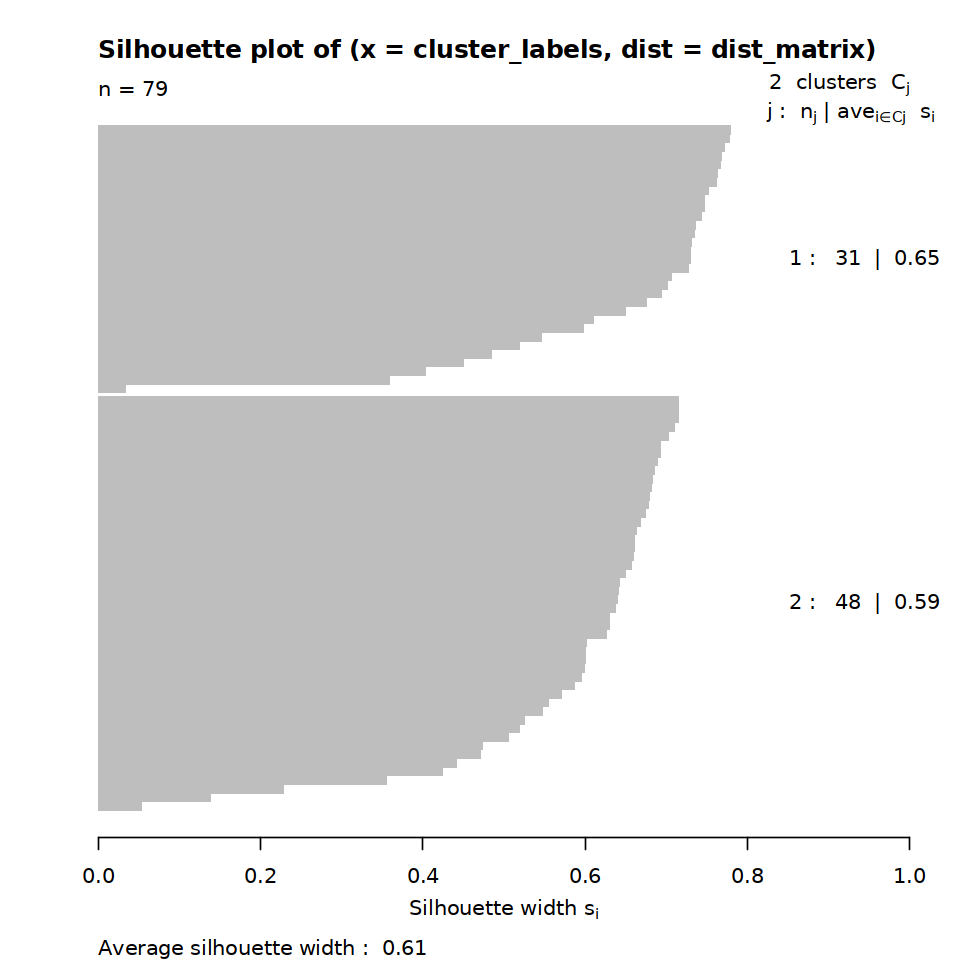

In [7]:
# Extract UMAP coordinates
umap_embeddings <- Embeddings(seurat_obj, reduction = "umap")

# Convert UMAP coordinates to a data frame
umap_df <- as.data.frame(umap_embeddings)
colnames(umap_df) <- c("UMAP_1", "UMAP_2")  # Rename columns

library(cluster)

# Convert categorical cluster labels to numeric
cluster_labels <- as.numeric(factor(seurat_obj$Group))
head(cluster_labels)

# Calculate Euclidean distance
dist_matrix <- dist(umap_df)

# Calculate silhouette scores
sil <- silhouette(cluster_labels, dist_matrix)
summary(sil)  # Summary of silhouette scores
plot(sil)

 # DIFERENTIAL EXPRESSION 

## EdgerR

In [8]:
# Combine the sample names
all_samples <- c(group1, group2)
# Create a factor vector for the groups
groups <- factor(rep(c("Group1", "Group2"), times = c(length(group1), length(group2))))
# If you want to name the samples in the groups vector:
names(groups) <- all_samples
# Create DGEList object

dge <- DGEList(counts = count_matrix[rowSums(is.na(count_matrix)) != ncol(count_matrix), ], group = groups)
# Filter low-count genes
keep <- filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes=T]
# Normalize the data
dge <- calcNormFactors(dge)
# Create design matrix
design <- model.matrix(~ groups)
# Estimate dispersion
dge <- estimateDisp(dge, design)
# Fit the model
fit <- glmQLFit(dge, design)
# Perform differential expression testing
qlf <- glmQLFTest(fit, coef=2)  # coef=2 compares the second group to the first
summary(decideTests(qlf))
edger_results <- topTags(qlf, n=Inf)$table
edger_results$FDR <- p.adjust(edger_results$PValue, method="BH")
kable(head(edger_results))

       groupsGroup2
Down            707
NotSig        14187
Up              996



|          |     logFC|    logCPM|        F| PValue| FDR|
|:---------|---------:|---------:|--------:|------:|---:|
|COX6B1    | -3.113384| 2.3597182| 87.55890|      0|   0|
|MT-TF     | -4.985912| 2.0076221| 75.46876|      0|   0|
|MYL12B    | -3.239032| 3.8476930| 73.44933|      0|   0|
|MT-TC     | -6.849470| 5.3032663| 72.00290|      0|   0|
|ISG15     | -3.114738| 0.3690454| 62.10889|      0|   0|
|EEF1A1P11 | -2.672204| 0.3390680| 61.25266|      0|   0|

## DESeq2

In [9]:
dds <- DESeqDataSetFromMatrix(countData = count_matrix[rowSums(is.na(count_matrix)) != ncol(count_matrix), ],
                              colData = data.frame(Group = clinical[colnames(count_matrix),]$Group,row.names = rownames(clinical[colnames(count_matrix),])),
                              design = ~ Group)
dds <- DESeq(dds)
deseq_results <- results(dds)
names(deseq_results)[names(deseq_results)=="log2FoldChange"] <- "logFC"
names(deseq_results)[names(deseq_results)=="pvalue"] <- "PValue"
deseq_results$FDR <- p.adjust(deseq_results$PValue, method="BH")
deseq_results <- as.data.frame(deseq_results)
kable(head(deseq_results))

print(results(dds)@elementMetadata$description)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3228 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing





|         |     baseMean|      logFC|     lfcSE|       stat|    PValue|      padj|       FDR|
|:--------|------------:|----------:|---------:|----------:|---------:|---------:|---------:|
|A1BG     | 9.199172e+00| -3.0201857| 0.3260092| -9.2641125| 0.0000000| 0.0000000| 0.0000000|
|A1BG-AS1 | 8.043874e-01| -3.3893761| 0.8453406| -4.0094796| 0.0000609|        NA| 0.0010269|
|A1CF     | 9.804630e-02| -0.7813702| 1.9754694| -0.3955364| 0.6924470|        NA| 0.9992306|
|A2M      | 4.559726e+04| -2.3429927| 0.2917615| -8.0305079| 0.0000000| 0.0000000| 0.0000000|
|A2M-AS1  | 1.363806e-01| -0.1744307| 1.3449647| -0.1296916| 0.8968104|        NA| 0.9992306|
|A2ML1    | 1.854074e+02|  0.7753743| 0.6615569|  1.1720447| 0.2411791| 0.4344407| 0.6170015|

[1] "mean of normalized counts for all samples"     
[2] "log2 fold change (MLE): Group Group2 vs Group1"
[3] "standard error: Group Group2 vs Group1"        
[4] "Wald statistic: Group Group2 vs Group1"        
[5] "Wald test p-value: Group Group2 vs Group1"     
[6] "BH adjusted p-values"                          


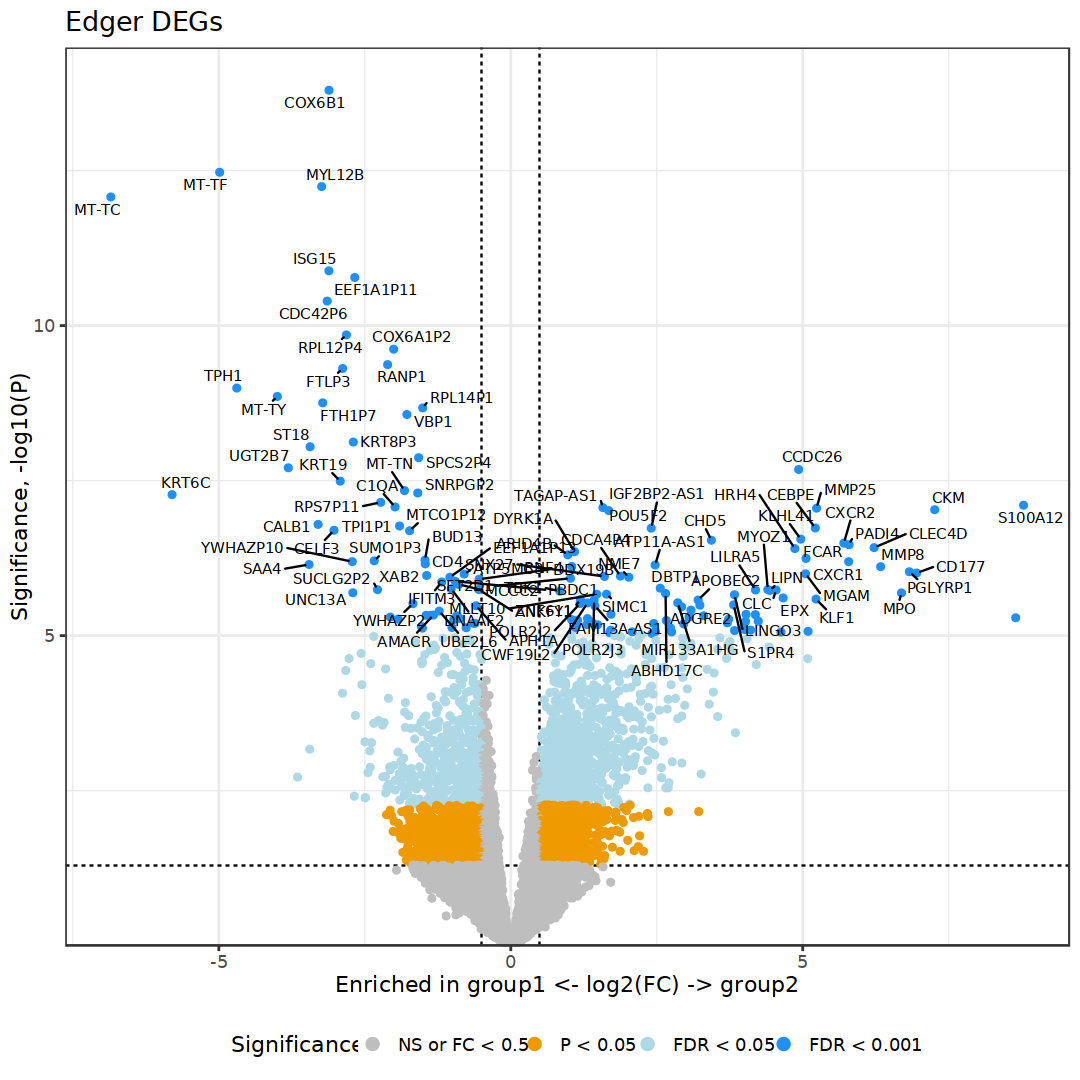

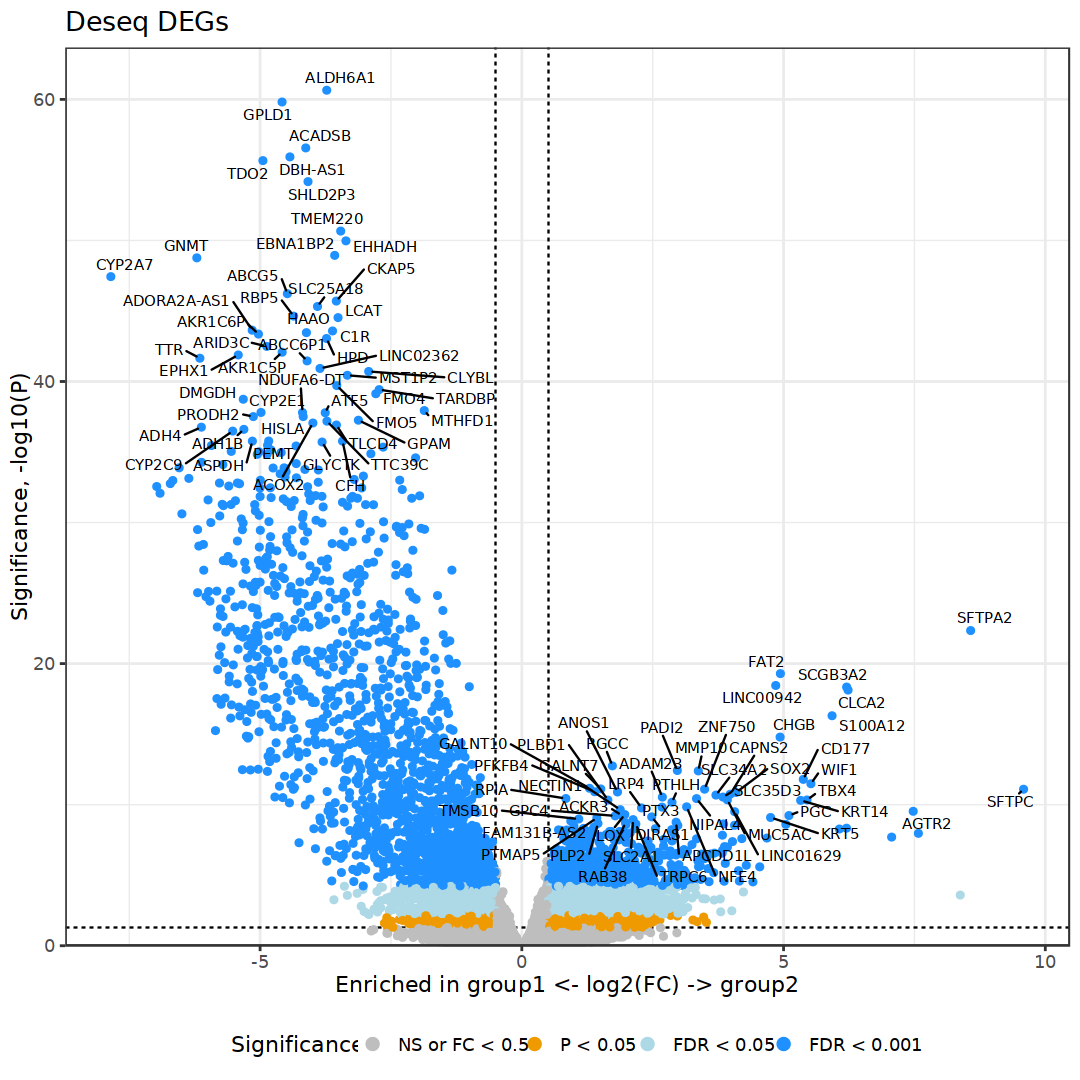

In [10]:
options(repr.plot.width=9, repr.plot.height=9)
number_of_genes = 50
edger_extremes <- extreme_genes_edger(edger_results,number_of_genes)
volcano_edger(edger_results,
              left = 'group1',
              right = 'group2',
              title = 'Edger DEGs',
              edger_extremes$pos,edger_extremes$neg)

deseq_extremes <- extreme_genes_edger(deseq_results,number_of_genes)
volcano_edger(deseq_results,
              left = 'group1',
              right = 'group2',
              title = 'Deseq DEGs',
              deseq_extremes$pos,deseq_extremes$neg)
options(repr.plot.width=NULL, repr.plot.height=NULL)

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



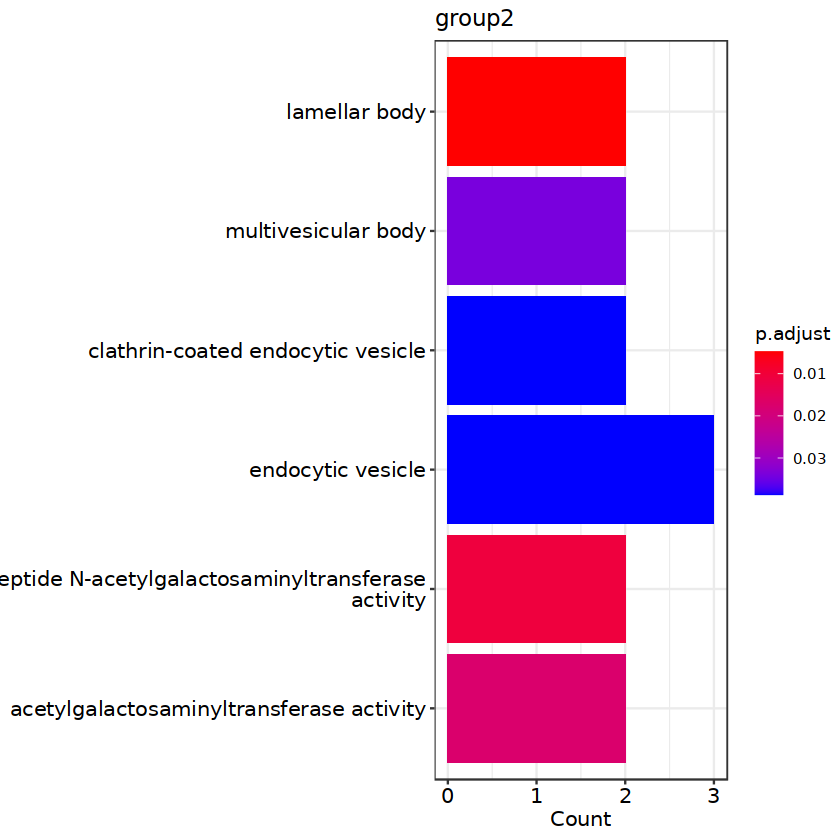

'select()' returned 1:1 mapping between keys and columns



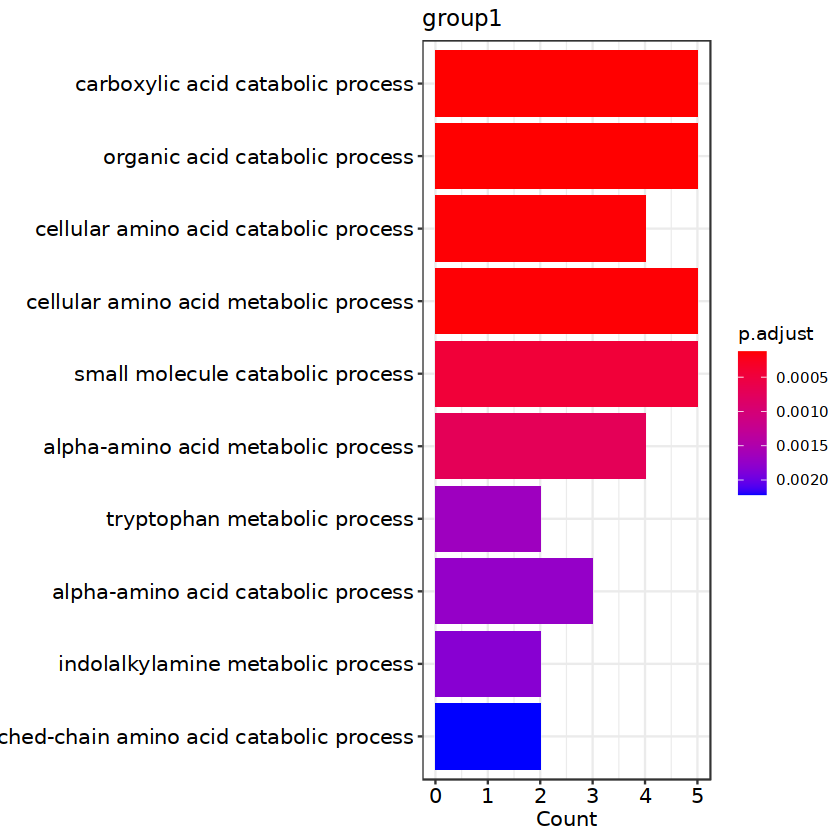

'select()' returned 1:1 mapping between keys and columns



NULL

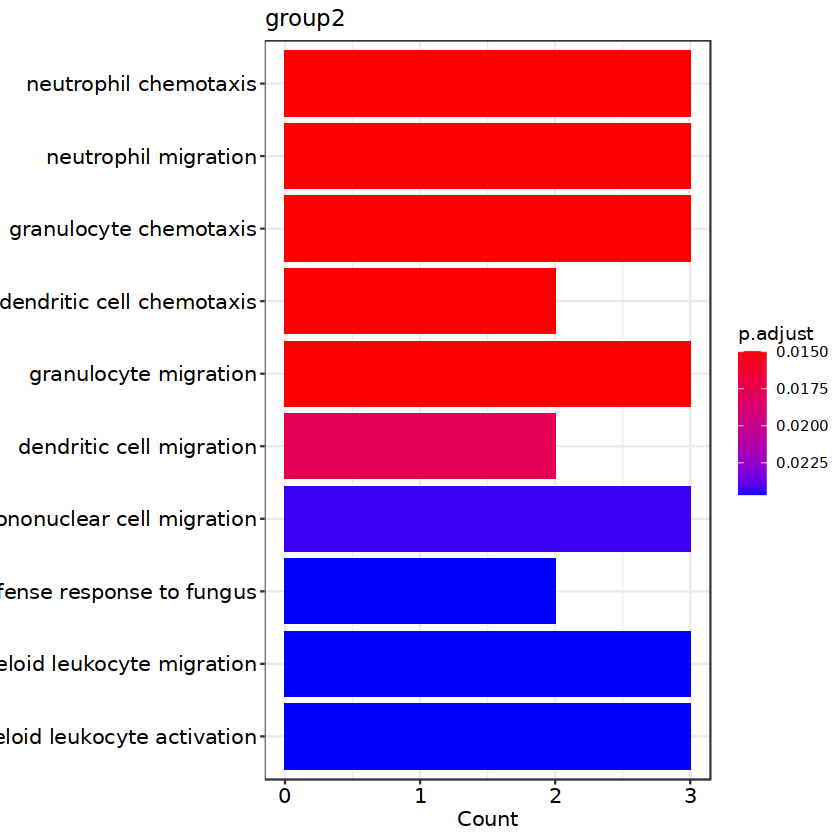

In [11]:
deseq_extremes <- extreme_genes_edger(deseq_results,20)
plot_ontology(deseq_extremes$pos,'group2')
plot_ontology(deseq_extremes$neg,'group1')

edger_extremes <- extreme_genes_edger(edger_results,20)
plot_ontology(edger_extremes$pos,'group2')
plot_ontology(edger_extremes$neg,'group1')

# Pheatmaps

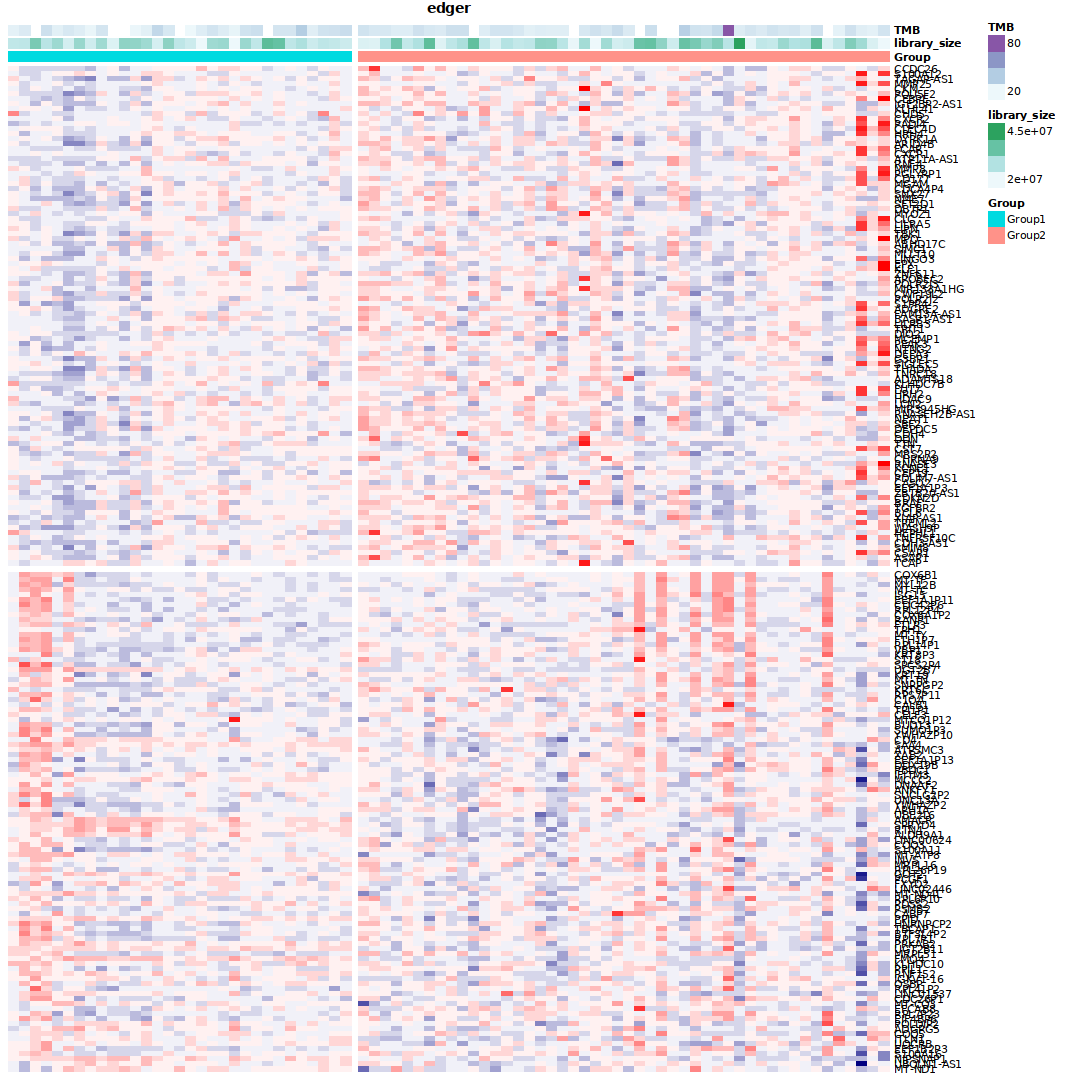

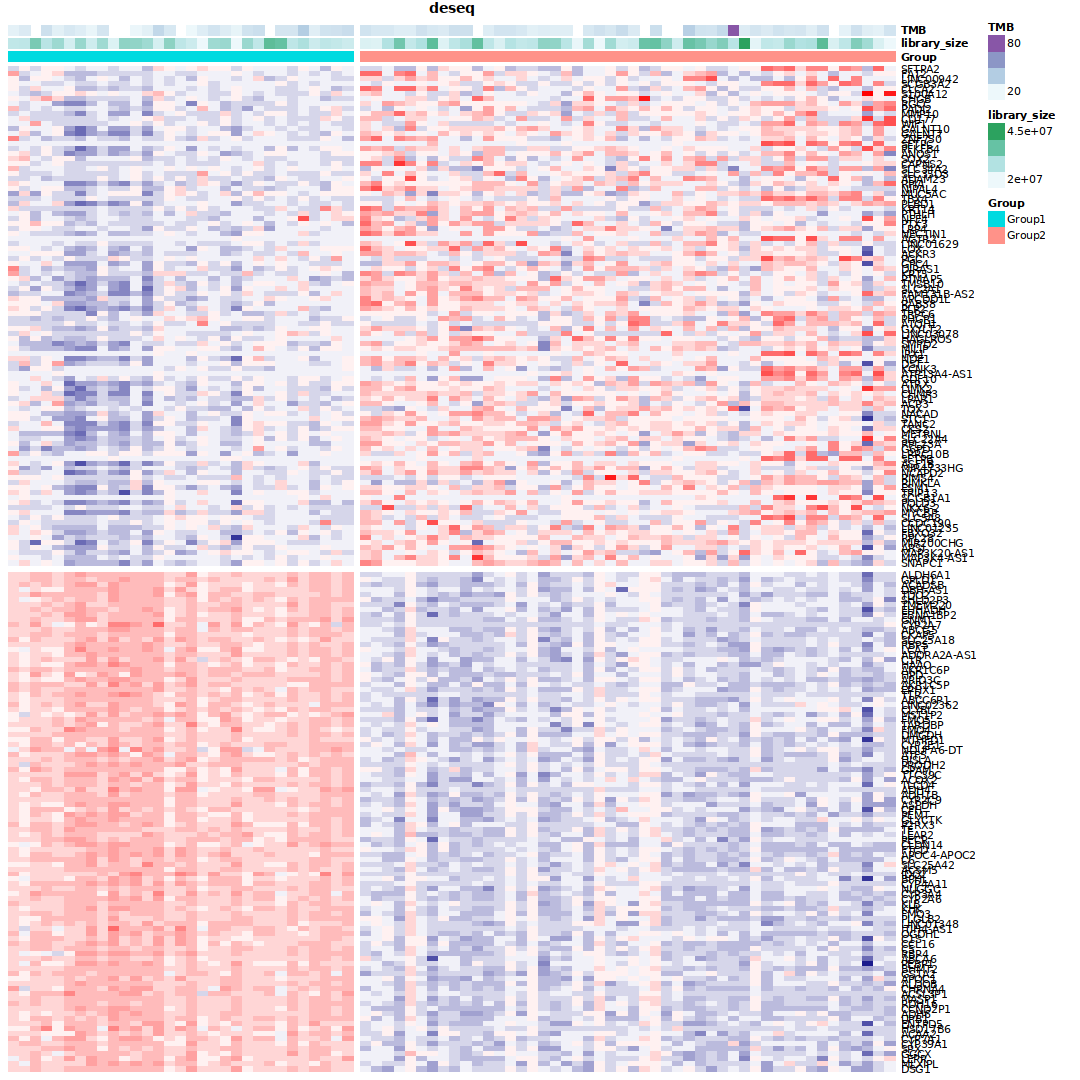

In [12]:
options(repr.plot.width=9, repr.plot.height=9)
#,"TMB","KRAS", "TP53", "ARID1A", "SMAD4", "KMT2D", "KMT2C", "CDKN2A", "RELN", "UPF1", "NCOR2", "AGO2"
annotation_col <- clinical[colnames(count_matrix),c("Group","library_size",'TMB')]
annotation_col <- annotation_col[order(annotation_col$Group),]

edger_extremes <- extreme_genes_edger(edger_results,100)
edger_goi <- c(edger_extremes$pos,edger_extremes$neg)
deseq_extremes <- extreme_genes_edger(deseq_results,100)
deseq_goi <- c(deseq_extremes$pos,deseq_extremes$neg)
logcpm <- edgeR::cpm(count_matrix,log=T)

pheatmap(logcpm[edger_goi,all_samples], scale = "row",main='edger', 
         show_rownames = T, show_colnames = F,
         border_color = NA,
         clustering_method = "average",
         #clustering_distance_rows = "correlation",
         cluster_cols = F, cluster_rows =F,
         gaps_col = length(group1), gaps_row = length(edger_extremes$pos),
         cutree_cols = 2, cutree_rows = 2,
         treeheight_row =0,treeheight_col = 0,
         #breaks = seq(-3, 3, 0.05),
         legend = F, annotation_legend = T, annotation_names_row =T,fontsize_row=6, fontsize=6,
         color = colorRampPalette(c("navy","white","red"))(20),
         annotation_col = annotation_col
         )

pheatmap(logcpm[deseq_goi,all_samples], scale = "row",main='deseq', 
         show_rownames = T, show_colnames = F,
         border_color = NA,
         clustering_method = "average",
         #clustering_distance_rows = "correlation",
         cluster_cols = F, cluster_rows =F,
         gaps_col = length(group1), gaps_row = length(deseq_extremes$pos),
         cutree_cols = 2, cutree_rows = 2,
         treeheight_row =0,treeheight_col = 0,
         #breaks = seq(-3, 3, 0.05),
         legend = F, annotation_legend = T, annotation_names_row =T,fontsize_row=6, fontsize=6,
         color = colorRampPalette(c("navy","white","red"))(20),
         annotation_col = annotation_col
         )
options(repr.plot.width=NULL, repr.plot.height=NULL)

# ontology plot

In [13]:
deseq_extremes <- extreme_genes_edger(deseq_results,50)
deseq_pos_ontology <- get_ontology(deseq_extremes$pos)
deseq_neg_ontology <- get_ontology(deseq_extremes$neg)

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



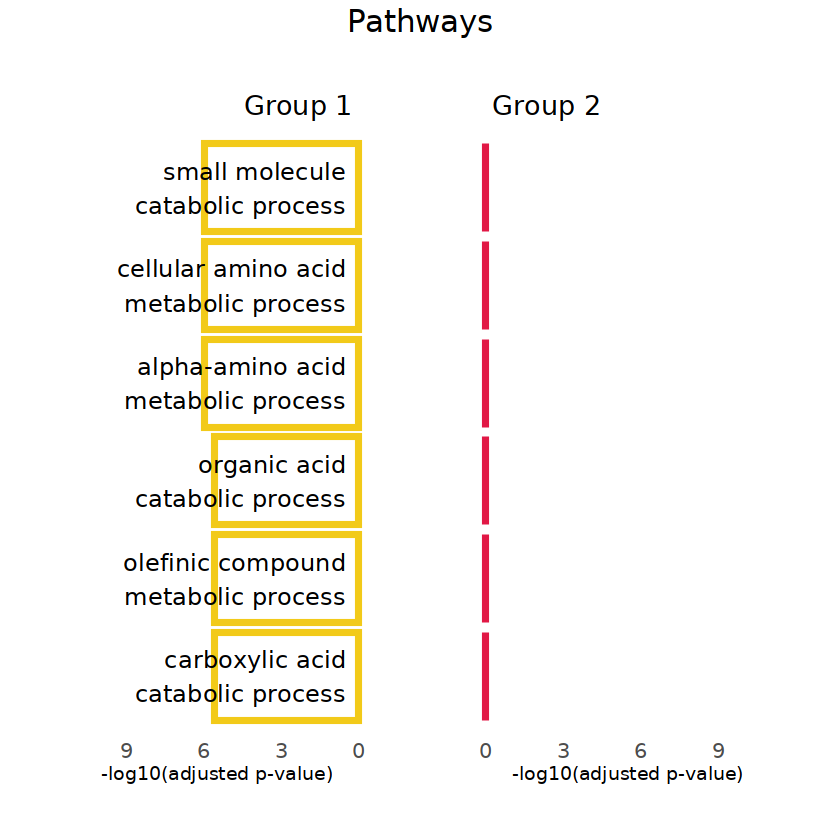

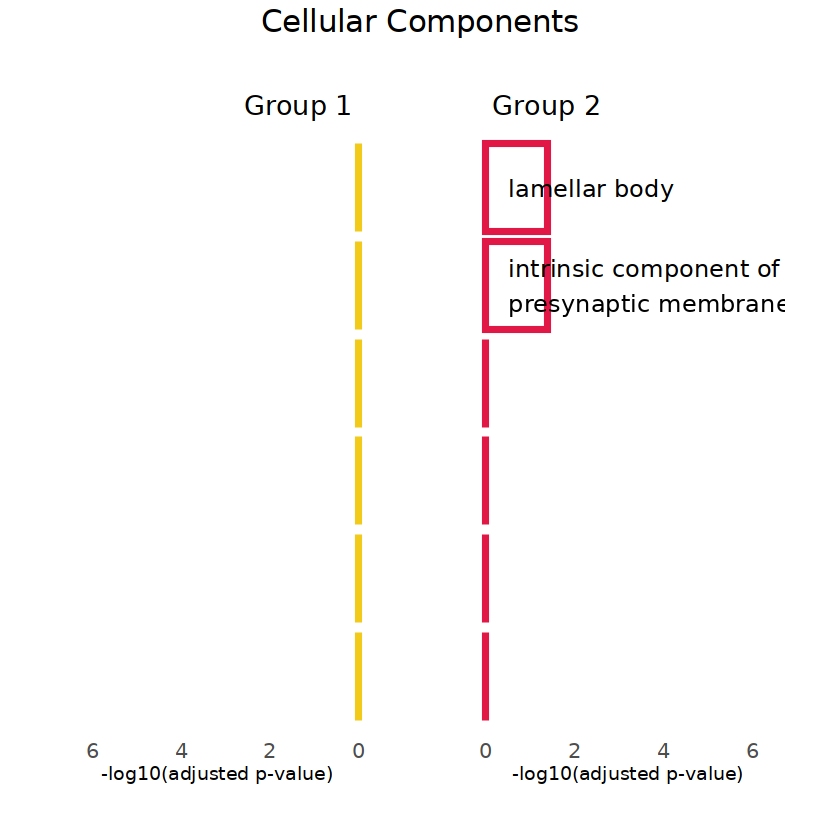

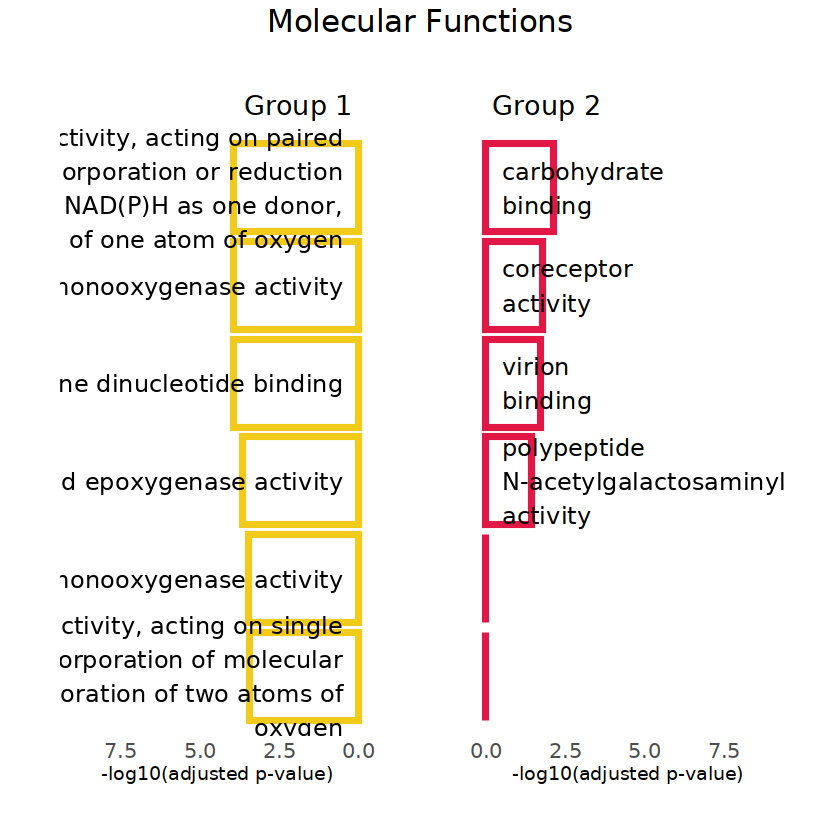

In [14]:
library(ggplot2)
library(dplyr)
library(patchwork)

go_ggplot <- function(df, color, max_x, max_terms, right = TRUE,linewidth) {
    library(ggplot2)
    library(dplyr)
    
    # Data preparation
    bar_width <- 1.5
    plot_data <- df %>%
        mutate(neg_log10_p_adjust = -log10(p.adjust)) %>%
        arrange(desc(neg_log10_p_adjust)) %>%
        head(max_terms) 
    
    plot_data <- plot_data[, c('neg_log10_p_adjust', 'Description')]
    
    
    
    plot_data <- plot_data %>%
        mutate(Description = str_wrap(Description, width = linewidth))
    
    
    
    empty_slots <- max_terms - nrow(plot_data)
    if (empty_slots > 0) {
        # Create dummy data for empty bars
        dummy_data <- data.frame(
            neg_log10_p_adjust = rep(0, empty_slots),
            Description = paste("", 1:empty_slots)
        )
        plot_data <- rbind(plot_data, dummy_data)
    }
    # Create base plot
    p <- ggplot(plot_data, aes(x = neg_log10_p_adjust, y = reorder(Description, neg_log10_p_adjust))) +
        theme_minimal() +
        labs(x = "-log10(adjusted p-value)", y = NULL) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text = element_text(size = 12),
            plot.margin = margin(1, 1, 1, 1, "cm"),
            axis.text.y = element_blank()  # Remove default y-axis text
        )
    
    # Add bars and text separately
    if (!right) {
        p <- p +
            geom_bar(stat = "identity", 
                     fill = "white",
                     color = color,
                     size = bar_width) +
            scale_x_reverse(limits = c(max_x + 5, 0)) +
            geom_text(aes(x = 0.5, label = Description),
                      hjust = 1,
                      size = 5,
                      data = plot_data %>% filter(neg_log10_p_adjust > 0)) +
            ggtitle("Group 1") +
            theme(plot.title = element_text(size = 16, hjust = 0.9))
    } else {
        p <- p +
            geom_bar(stat = "identity", 
                     fill = "white",
                     color = color,
                     size = bar_width) +
            scale_x_continuous(limits = c(0, max_x + 5)) +
            geom_text(aes(x = 0.5, label = Description),
                      hjust = 0,
                      size = 5,
                      data = plot_data %>% filter(neg_log10_p_adjust > 0)) +
            ggtitle("Group 2") +
            theme(plot.title = element_text(size = 16, hjust = 0.1))
    }
    
    return(p)
}

deseq_pos_ontology_BP <- deseq_pos_ontology[deseq_pos_ontology$ONTOLOGY == 'BP',]
deseq_neg_ontology_BP <- deseq_neg_ontology[deseq_neg_ontology$ONTOLOGY == 'BP',]

max_x <- max(c(-log10(deseq_pos_ontology_BP$p.adjust),-log10(deseq_neg_ontology_BP$p.adjust)))
p1 <- go_ggplot(deseq_neg_ontology_BP,group1_color,max_x, 6, right =F,20)
p2 <- go_ggplot(deseq_pos_ontology_BP,group2_color,max_x, 6, right =T,12)
pathways_ontologies_plot <- p1 + p2 + 
  plot_annotation(
    title = "Pathways",
    theme = theme(plot.title = element_text(size = 18,hjust = 0.5))  # Center the title
  )
pathways_ontologies_plot

deseq_pos_ontology_CC <- deseq_pos_ontology[deseq_pos_ontology$ONTOLOGY == 'CC',]
deseq_neg_ontology_CC <- deseq_neg_ontology[deseq_neg_ontology$ONTOLOGY == 'CC',]

max_x <- max(c(-log10(deseq_pos_ontology_CC$p.adjust),-log10(deseq_neg_ontology_CC$p.adjust)))
p1 <- go_ggplot(deseq_neg_ontology_CC,group1_color,max_x, 6, right =F,12)
p2 <- go_ggplot(deseq_pos_ontology_CC,group2_color,max_x, 6, right =T,30)
component_ontologies_plot <- p1 + p2 + 
  plot_annotation(
    title = "Cellular Components",
    theme = theme(plot.title = element_text(size = 18,hjust = 0.5))
  )
component_ontologies_plot

deseq_pos_ontology_MF <- deseq_pos_ontology[deseq_pos_ontology$ONTOLOGY == 'MF',]
deseq_neg_ontology_MF <- deseq_neg_ontology[deseq_neg_ontology$ONTOLOGY == 'MF',]
max_x <- max(c(-log10(deseq_pos_ontology_MF$p.adjust),-log10(deseq_neg_ontology_MF$p.adjust)))
p1 <- go_ggplot(deseq_neg_ontology_MF,group1_color,max_x, 6, right =F,42)
p2 <- go_ggplot(deseq_pos_ontology_MF,group2_color,max_x, 6, right =T,12)

functions_ontologies_plot <- p1 + p2 + 
  plot_annotation(
    title = "Molecular Functions",
    theme = theme(plot.title = element_text(size = 18,hjust = 0.5))
  )
functions_ontologies_plot

In [15]:
deseq_pos_ontology <- deseq_pos_ontology %>%
    mutate(neg_log10_p_adjust = -log10(p.adjust)) %>%
    arrange(desc(neg_log10_p_adjust))

deseq_neg_ontology <- deseq_neg_ontology %>%
    mutate(neg_log10_p_adjust = -log10(p.adjust)) %>%
    arrange(desc(neg_log10_p_adjust))
kable(deseq_pos_ontology)
kable(deseq_neg_ontology)
# writexl::write_xlsx(deseq_pos_ontology,"IGR_Cohort_group2_ontology.xlsx")
# writexl::write_xlsx(deseq_neg_ontology,"IGR_Cohort_group1_ontology.xlsx")



|           |ONTOLOGY |ID         |Description                                            |GeneRatio |BgRatio   |    pvalue|  p.adjust|    qvalue|geneID                             | Count| neg_log10_p_adjust|
|:----------|:--------|:----------|:------------------------------------------------------|:---------|:---------|---------:|---------:|---------:|:----------------------------------|-----:|------------------:|
|GO:0030246 |MF       |GO:0030246 |carbohydrate binding                                   |6/45      |271/18368 | 0.0000490| 0.0076013| 0.0059365|729238/55568/51809/22934/5806/5818 |     6|           2.119111|
|GO:0015026 |MF       |GO:0015026 |coreceptor activity                                    |3/45      |48/18368  | 0.0002200| 0.0170518| 0.0133172|5818/57007/2239                    |     3|           1.768230|
|GO:0046790 |MF       |GO:0046790 |virion binding                                         |2/45      |12/18368  | 0.0003814| 0.0197034| 0.0153880|5806/5818   



|           |ONTOLOGY |ID         |Description                                                                                                                                                                                 |GeneRatio |BgRatio   |    pvalue|  p.adjust|    qvalue|geneID                                             | Count| neg_log10_p_adjust|
|:----------|:--------|:----------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------|:---------|---------:|---------:|---------:|:--------------------------------------------------|-----:|------------------:|
|GO:0044282 |BP       |GO:0044282 |small molecule catabolic process                                                                                                                                                            |10/38     |376/18723 | 0.0000000| 0.0000010| 0.0000007|4

# ComplexHeatmap

In [16]:
options(repr.plot.width=NULL, repr.plot.height=NULL)  # Adjust size as needed
genes_to_show <- c("ALDH6A1", "CYP2A7", "LCAT", "CD177","CXCR2","MMP10")  # names of genes to show
logcpm <- edgeR::cpm(count_matrix,log=T)
data <- logcpm[deseq_goi,all_samples]
m = t(apply(data, 1, scale))
mutation_col = c(
    "SNP" = "black",
    "DEL" = "#4DAF4A",
    "DNP" = "#4DAF4A",
    "INS" = "#377EB8",
    "NA" = "white"
)
annotation_col <- clinical[colnames(count_matrix),c("Group","library_size",'TMB',"KRAS", "TP53", "ARID1A", "SMAD4", "KMT2D", "KMT2C", "CDKN2A", "RELN", "UPF1", "NCOR2", "AGO2")]
annotation_col <- annotation_col[order(annotation_col$Group),]

ha_right = rowAnnotation(pasok = anno_mark(at =c(1:6,101:106), labels = c(deseq_extremes$pos[1:6],deseq_extremes$neg[1:6])))
#ha_right = rowAnnotation(pasok = anno_mark(at =which(rownames(m) %in% genes_to_show), labels = genes_to_show))
ha_top = HeatmapAnnotation(Group = annotation_col[['Group']],
                          show_annotation_name = TRUE,
                          col = list(Group = c("Group1" = group1_color, "Group2" = group2_color)))
ha_bottom = HeatmapAnnotation(
    TMB = anno_points(annotation_col[['TMB']], 
    gp = gpar(col = ifelse(annotation_col[['TMB']] > 20, "black", "red")), 
    height = unit(3, "cm")),
        kras = annotation_col[['KRAS']],
        tp53   = annotation_col[['TP53']],
        arid1a = annotation_col[['ARID1A']],
        smad4  = annotation_col[['SMAD4']],
        kmt2d  = annotation_col[['KMT2D']],
        kmt2c  = annotation_col[['KMT2C']],
        cdkn2a = annotation_col[['CDKN2A']],
        reln   = annotation_col[['RELN']],
        upf1   = annotation_col[['UPF1']],
        ncor2  = annotation_col[['NCOR2']],
        ago2   = annotation_col[['AGO2']],
        col = list(kras = mutation_col,
                    tp53 = mutation_col,
                    arid1a = mutation_col,
                    smad4 = mutation_col,
                    kmt2d = mutation_col,
                    kmt2c = mutation_col,
                    cdkn2a = mutation_col,
                    reln = mutation_col,
                    upf1 = mutation_col,
                    ncor2 = mutation_col,
                    ago2 = mutation_col),
    show_legend = c(T, F, F, F, F, F, F, F, F, F, F),
    show_annotation_name = T,
    annotation_legend_param = list(
        tp53 = list(title = "TP53")
        )
    )
ht <- Heatmap(m, cluster_rows = F,show_heatmap_legend = F,
        cluster_columns = F, show_row_names = F,
        show_column_names = F, 
        column_split = c(rep("group1", length(group1)), rep("group2",length(group2))),
        row_split = c(rep('a', 100), rep('b',100)),
        row_gap = unit(2, "mm"),
        column_gap = unit(2, "mm"),
        right_annotation = ha_right,
        top_annotation = ha_top,
        #bottom_annotation = ha_bottom,
        col = colorRamp2(c(-4, -2, 0, 2, 4),c("blue", "lightblue", "white", "pink", "red"))
        )

pdf("temp.pdf")
draw(ht)
dev.off()

pdf 
  2

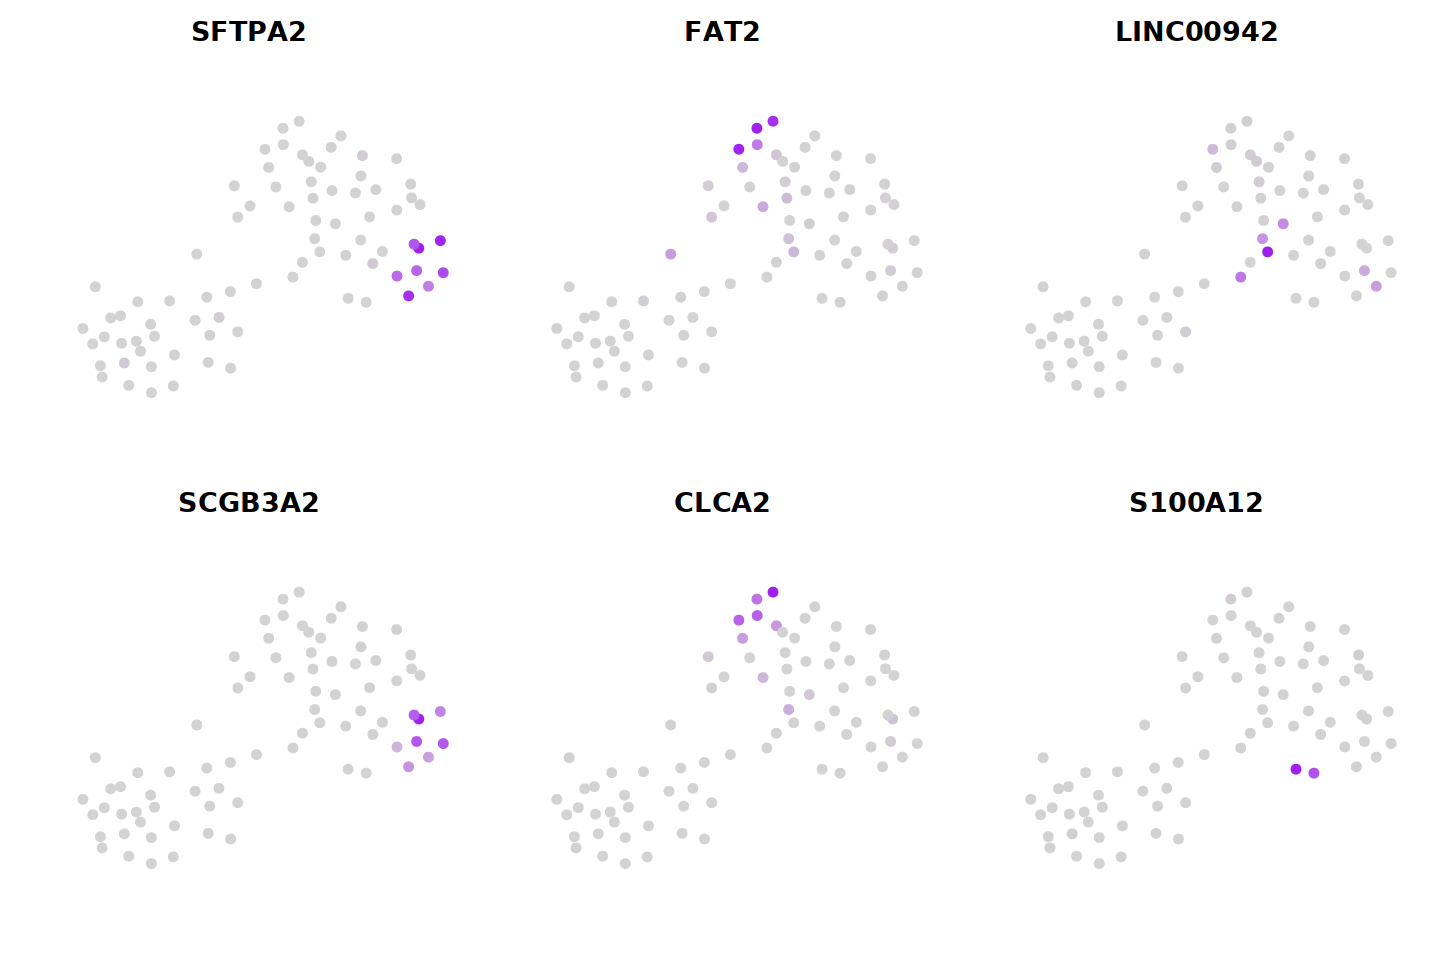

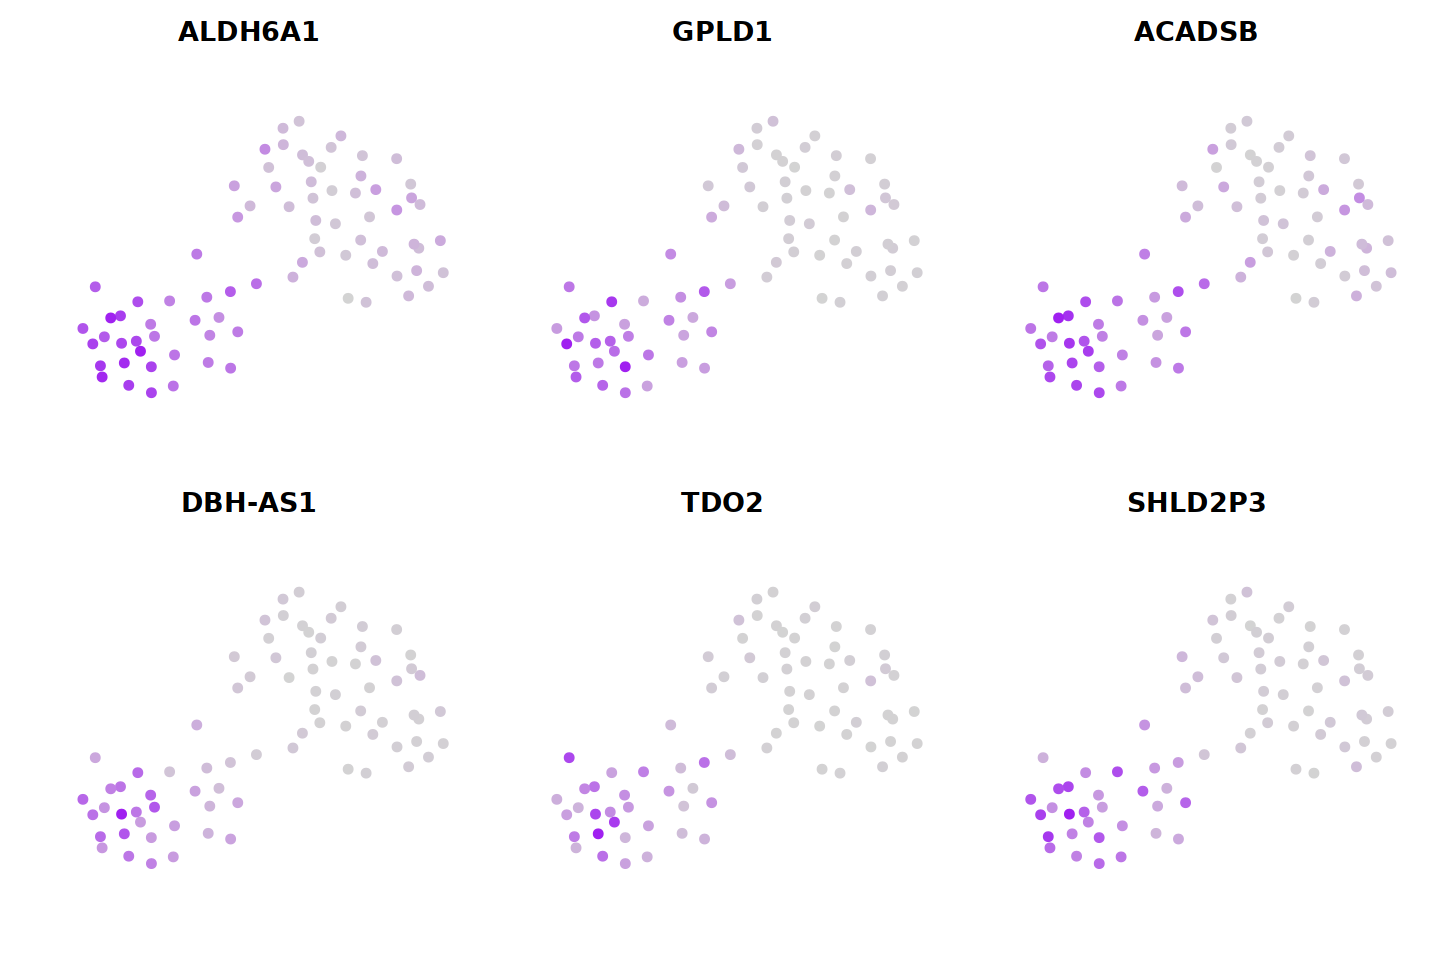

In [17]:
options(repr.plot.width=12, repr.plot.height=8)

genes_to_show <- c("ALDH6A1", "CYP2A7", "LCAT", "CD177","CXCR2","MMP10")
p1  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$pos[1], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p2  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$pos[2], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p3  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$pos[3], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p4  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$pos[4], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p5  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$pos[5], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p6  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$pos[6], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())
combined_plot <- (p1 + p2 + p3 + p4 + p5 + p6 ) + plot_layout(nrow = 2, ncol = 3) 
print(combined_plot)

p1  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$neg[1], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p2  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$neg[2], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p3  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$neg[3], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p4  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$neg[4], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p5  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$neg[5], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
p6  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =deseq_extremes$neg[6], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())
combined_plot <- (p1 + p2 + p3 + p4 + p5 + p6 ) + plot_layout(nrow = 2, ncol = 3) 
print(combined_plot)

# options(repr.plot.width=12, repr.plot.height=4)
# p1  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =genes_to_show[1], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
# p2  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =genes_to_show[2], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
# p3  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =genes_to_show[3], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
# p4  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =genes_to_show[4], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
# p5  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =genes_to_show[5], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(), axis.ticks = element_blank(), axis.text = element_blank(),axis.title = element_blank())
# p6  <- FeaturePlot(object = seurat_obj, reduction = "umap", features =genes_to_show[6], pt.size = 2, cols = c("lightgrey", "purple")) + theme(legend.position = "none",panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())
# combined_plot <- (p1 + p2 + p3 ) + plot_layout(nrow = 1, ncol = 3) 
# print(combined_plot)
# combined_plot <- (p4 + p5 + p6 ) + plot_layout(nrow = 1, ncol = 3) 
# print(combined_plot)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


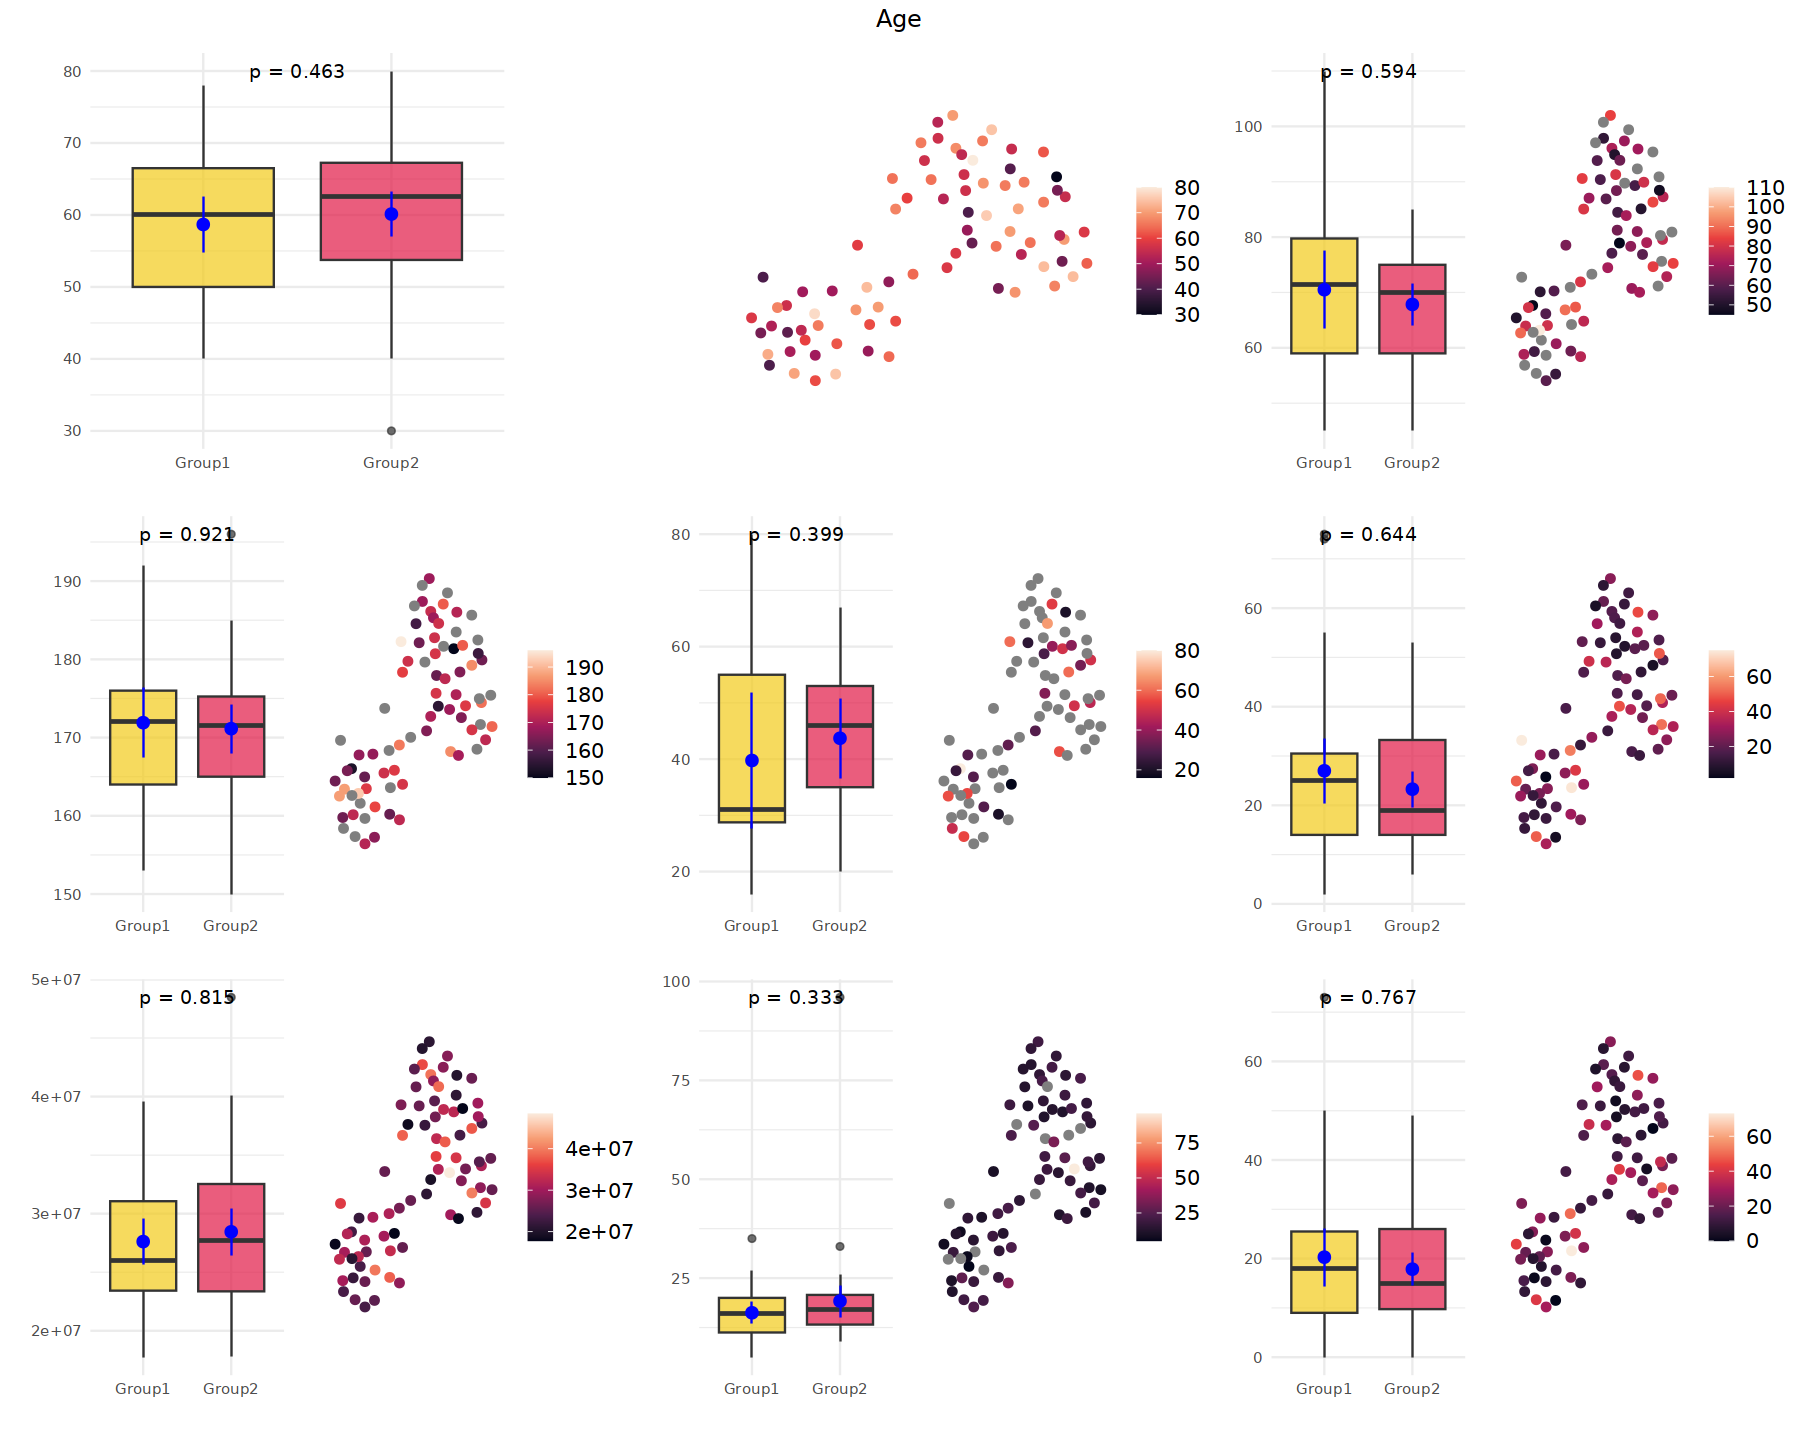

In [18]:
plot_test <- function(seurat, column,title) {
    data <- seurat@meta.data
    # Perform Mann-Whitney U test
    formula <- paste(column, "~ Group")
    test_result <- wilcox.test(as.formula(formula), data = data, alternative = "two.sided")
    # Function to calculate mean and confidence interval
    mean_ci <- function(x) {
        mean <- mean(x)
        ci <- qt(0.975, df = length(x) - 1) * sd(x) / sqrt(length(x))
        return(c(y = mean, ymin = mean - ci, ymax = mean + ci))
    }

    # Create the boxplot with p-value
    a <- ggplot(data, aes(x = Group, y = get(column), fill = Group)) +
    geom_boxplot(alpha = 0.7) +
    stat_summary(fun.data = mean_ci, geom = "pointrange", color = "blue", size = 0.5) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(legend.position = "none",
          plot.title = element_blank()) +  # Remove individual plot title
    scale_fill_manual(values = c("Group1" = group1_color, 'Group2' = group2_color))  # Assign colors to each bar
    y_max = max(data[[column]][!is.na(data[[column]])])

    # Add p-value to the plot
    a <- a + annotate("text", x = 1.5, y = y_max, 
      label = paste("p =", format.pval(test_result$p.value, digits = 3)),
      size = 4)
    
    b <- FeaturePlot(object = seurat, reduction = "umap", features = column, pt.size = 2) +
            scale_color_viridis_c(option = "rocket") + 
            theme(panel.border = element_blank(), 
                axis.line = element_blank(),
                axis.ticks = element_blank(),
                axis.text = element_blank(),
                axis.title = element_blank(),
                plot.title = element_blank())  # Remove individual plot title
    
    # Combine plots and add a common title
    p <- (a + b) + 
         plot_annotation(title = title, theme = theme(plot.title = element_text(hjust = 0.5, size = 14)))
    
    return(p)
}

p1 <- plot_test(seurat_obj,"Age","Age")
#print(p1)
p2 <- plot_test(seurat_obj,"Weight","Weight")
#print(p2)
p3 <- plot_test(seurat_obj,"Height_cm","Height")
#print(p3)
p4 <- plot_test(seurat_obj,"Tumor_dim_mm","Tumor size (mm)")
#print(p4)
p5 <- plot_test(seurat_obj,"survival","Survival")
#print(p5)
p6 <- plot_test(seurat_obj,"library_size", "Library Size")
#print(p6)
p7 <- plot_test(seurat_obj,"TMB","Mutation Burden")
#print(p7)
p8 <- plot_test(seurat_obj,"tumor_age", "Tumor Age")
#print(p8)
options(repr.plot.width=15, repr.plot.height=12) # Adjust size as needed

combined_plot <- (p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8) + plot_layout( ncol = 3) 
print(combined_plot)
options(repr.plot.width=NULL, repr.plot.height=NULL) # Adjust size as needed


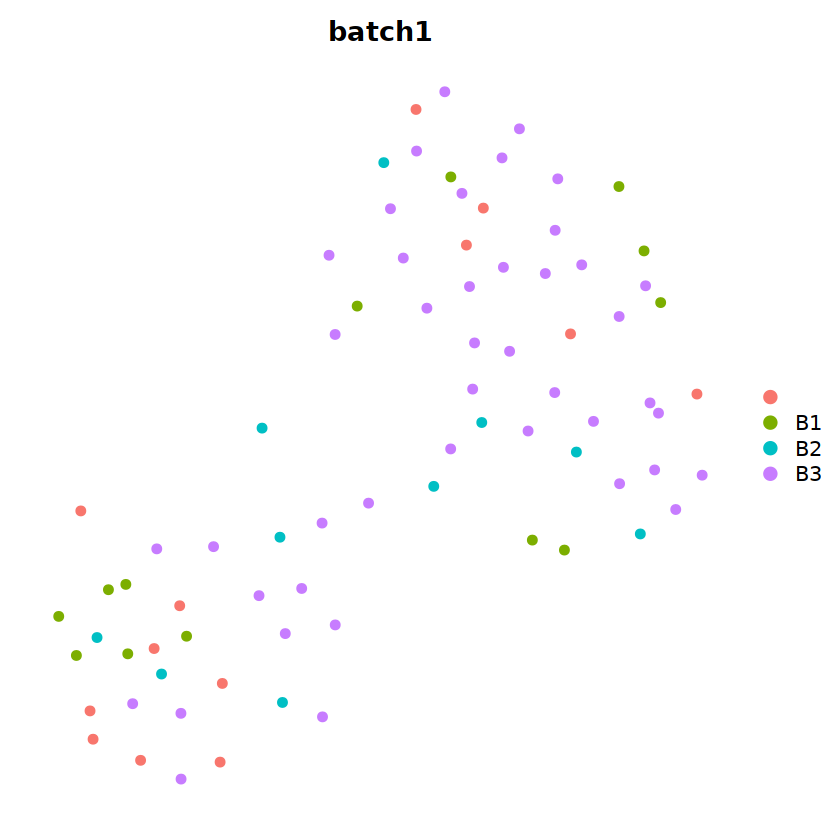

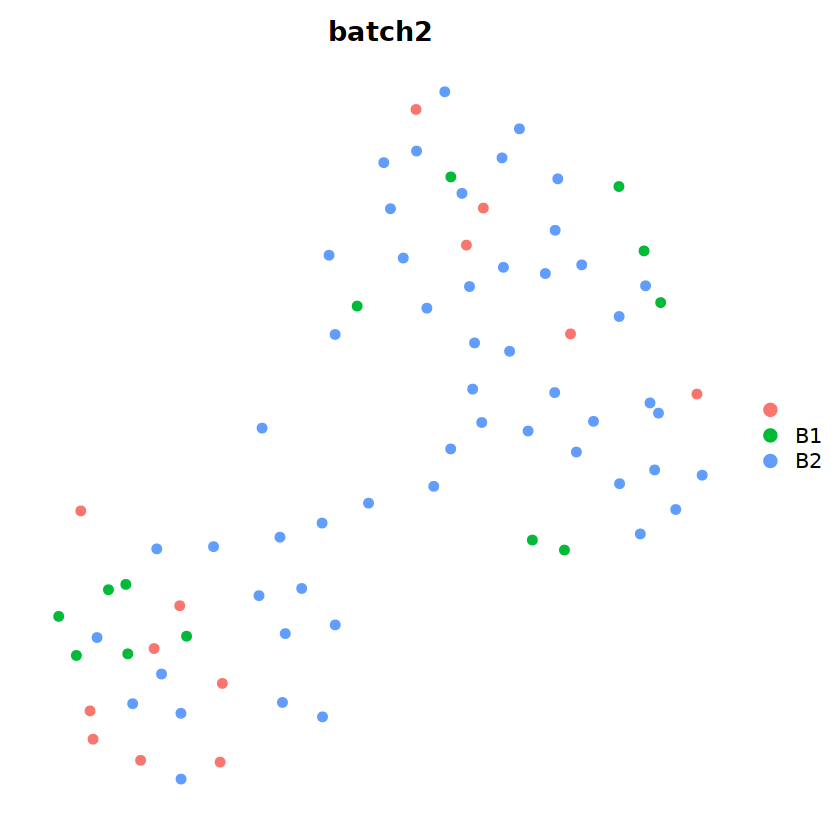

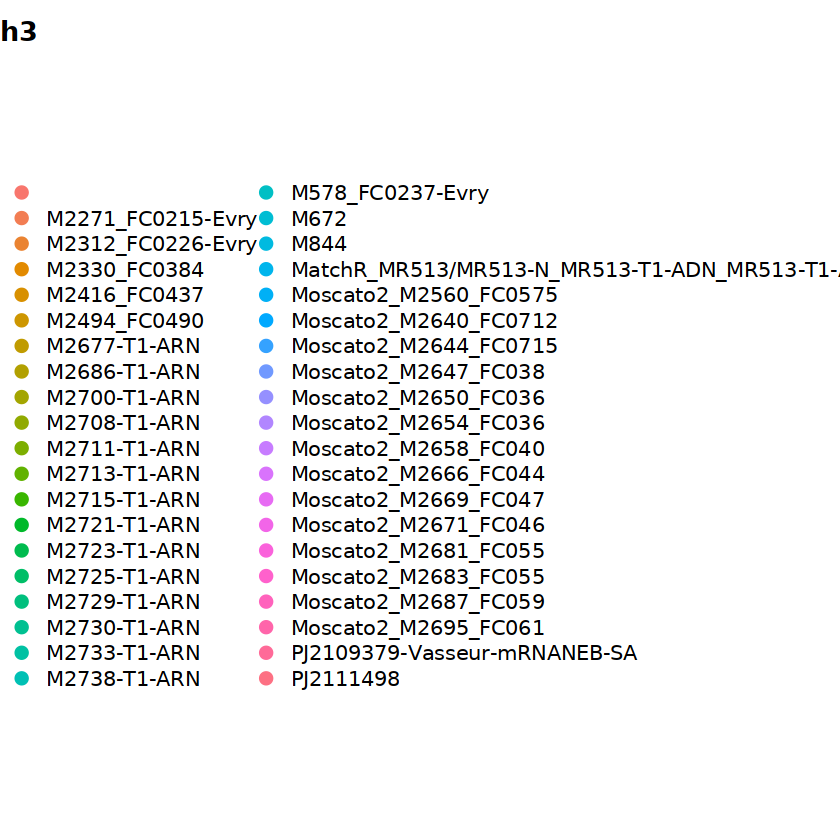

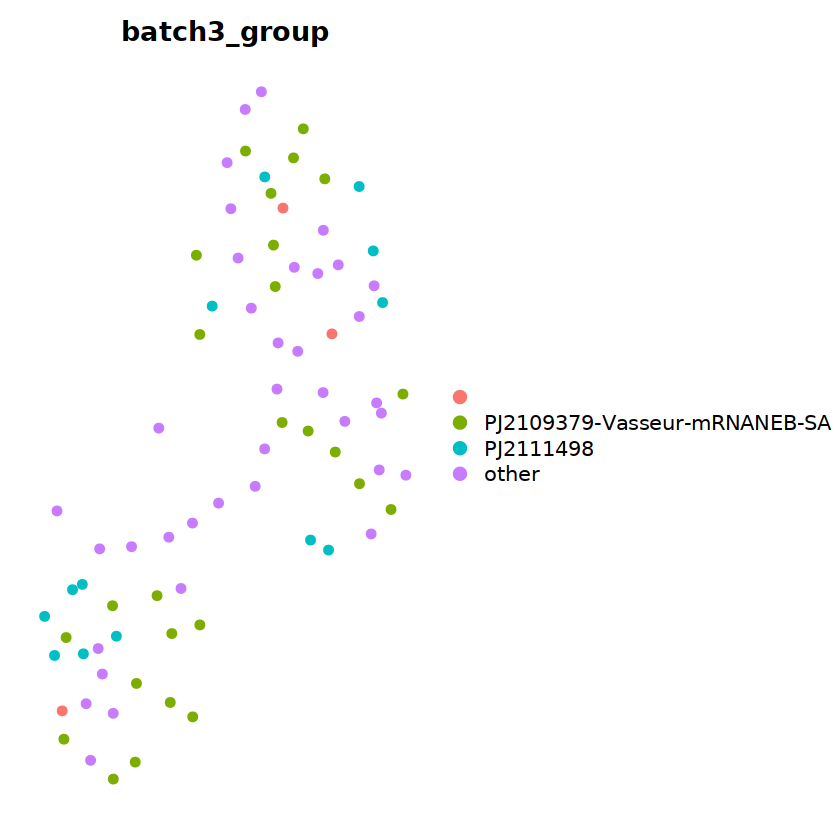

In [19]:
DimPlot(object = seurat_obj, reduction = "umap", group.by = "batch1", pt.size = 2) + theme(panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())
DimPlot(object = seurat_obj, reduction = "umap", group.by = "batch2", pt.size = 2) + theme(panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())
DimPlot(object = seurat_obj, reduction = "umap", group.by = "batch3", pt.size = 2) + theme(panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())
DimPlot(object = seurat_obj, reduction = "umap", group.by = "batch3_group", pt.size = 2) + theme(panel.border = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),axis.text = element_blank(),axis.title = element_blank())

In [20]:
combined_umaps <- function(seurat,features){
	plot_list <- list()
	for (i in seq_along(features)) {
		feature = features[i]
		if (is.numeric(seurat@meta.data[[feature]])) {
			plot_list[[i]] <- FeaturePlot(object = seurat, reduction = "umap", features = feature, pt.size = 2) +
			scale_color_viridis_c(option = "rocket") 
		} else if (feature == "Biopsie_tissue") {
			plot_list[[i]] <- DimPlot(object = seurat, reduction = "umap", group.by = feature, pt.size = 2) + ggtitle("Biopsy Site")
		} else {
            plot_list[[i]] <- DimPlot(object = seurat, reduction = "umap", group.by = feature, pt.size = 2) +
			theme(legend.position = "none")            
        }

		plot_list[[i]] <- plot_list[[i]] + theme(panel.border = element_blank(), 
							 axis.line = element_blank(),
							 axis.ticks = element_blank(),
							 axis.text = element_blank(),
							 axis.title = element_blank(),
                             plot.title = element_text(size = 10))
	}
	combined_plot <- wrap_plots(plot_list, ncol = 3)
	return(combined_plot)
}
##################################################################################################################
biological_features <- c("Sex", "Age", "Weight", "Height_cm", "Cause_of_Death", "Thrombose", "Alcool", "Smoking", "Diabetes", "Tumor_dim_mm",  "Biopsie_Date")
technical_features  <- c("library_size","Biopsie_tissue", "cellularity", "autre_cassete_dispo.20.", "arn_restant", "batch1", "batch2", "site.biopsie", "meta.site.histo", "batch3_group","organisation", "technicalPlatform")
other_features <- c("cnv_cluster", "Biopsy_Site", "diagnosis_date", "survival", "age_cat", "tumor_age", "kras", "tp53")
treatment_features  <- c("Non.alkylating.chemo", "Platinum.salts", "TKIs", "MAPK", "PI3K.Akt", "DDR", "Macrophages", "ICI")
high_cramer <- c("Biopsie_Date", "batch3", "Biopsie_tissue","Diagnosis","arn_restant","Biopsy_Site")
seurat_obj@meta.data[treatment_features] <- lapply(seurat_obj@meta.data[treatment_features], as.factor)
seurat_obj@meta.data[c('cnv_cluster')] <- lapply(seurat_obj@meta.data[c('cnv_cluster')], as.factor)

In [21]:
library(cowplot)
biological_features <- c("Sex",  "Age",  "Weight", "Height_cm",  "Alcool", "Smoking", "Diabetes", "Tumor_dim_mm", "Biopsie_tissue")

# p1 <- combined_umaps(seurat_obj,biological_features)
# print(p1)
cat_umap <- function (seurat,feature,title,pos) {
    p <- DimPlot(object = seurat, reduction = "umap", group.by = feature, pt.size = 2) + 
    theme(panel.border = element_blank(), 
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title = element_blank(),
        plot.title = element_text(size = 10)) + 
    theme(legend.position = pos) +
    ggtitle(title)
    return(p)
}
num_umap <- function (seurat,feature,title,pos) {
    p <- FeaturePlot(object = seurat, reduction = "umap", features = feature, pt.size = 2) + 
    scale_color_viridis_c(option = "rocket") + 
    theme(panel.border = element_blank(), 
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title = element_blank(),
        plot.title = element_text(size = 10)) +
    theme(legend.position = pos) +
    ggtitle(title)
    return(p)
}


Attaching package: 'cowplot'


The following object is masked from 'package:patchwork':

    align_plots


The following object is masked from 'package:lubridate':

    stamp




In [22]:
seurat_obj@meta.data <- clinical
seurat_obj@meta.data <- seurat_obj@meta.data %>%
  mutate(Diabetes = recode(Diabetes, "Apr\303\250s le diagnostic" = "after diagnosis",
                                     "Non sp\303\251cifi\303\251" = "not specified",
                                     "Pas de diab\303\250te" = "no",
                                     "Avant le diagnostic" = "before diagnosis"))

seurat_obj@meta.data <- seurat_obj@meta.data %>%
  mutate(Alcool = recode(Alcool, "non sp\303\251cifi\303\251" = "not specified",
                                     "non" = "no", "oui" = "yes"))

seurat_obj@meta.data <- seurat_obj@meta.data %>%
  mutate(Sex = recode(Sex,"Femme" = "female", "Homme" = "male" ))

seurat_obj@meta.data <- seurat_obj@meta.data %>%
  mutate(Sex = recode(Sex,"Femme" = "female", "Homme" = "male" ))

seurat_obj@meta.data <- seurat_obj@meta.data %>%
  mutate(Smoking = recode(Smoking,"non sp<U+00E9>cifi<U+00E9>" = "not specified",
                          "non" = "no","oui"="yes" ))
seurat_obj@meta.data <- seurat_obj@meta.data %>%
  mutate(Biopsie_tissue = recode(Biopsie_tissue,
         "BIOPSIE PAS ENCORE FAITE, FOIE" = "Liver",
         "FOIE" = "Liver",
         "ENDO"= "Endo",
         "HEPATIQUE" = "Liver",
                                 "FOIE, POUMON"="Liver, Lung",
         "MASSE PELVIENNE" = "Pelvic",
         "PERITONEAL" = "Peritoneum",
         "R\303\211TRO P\303\211RITON\303\211AL" ="Peritoneum",
                                 "FOIE, H\303\211PATIQUE"="Liver",
                                 "SUS-CLAVICULAIRE GAUCHE" = "lymph node"
        ))
table(seurat_obj@meta.data$Biopsie_tissue)


       Endo GG CERVICAL       Liver Liver, Lung         NAN          OS 
          1           2          60           1           2           1 
     POUMON      Pelvic  Peritoneum  lymph node 
          8           1           2           1 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


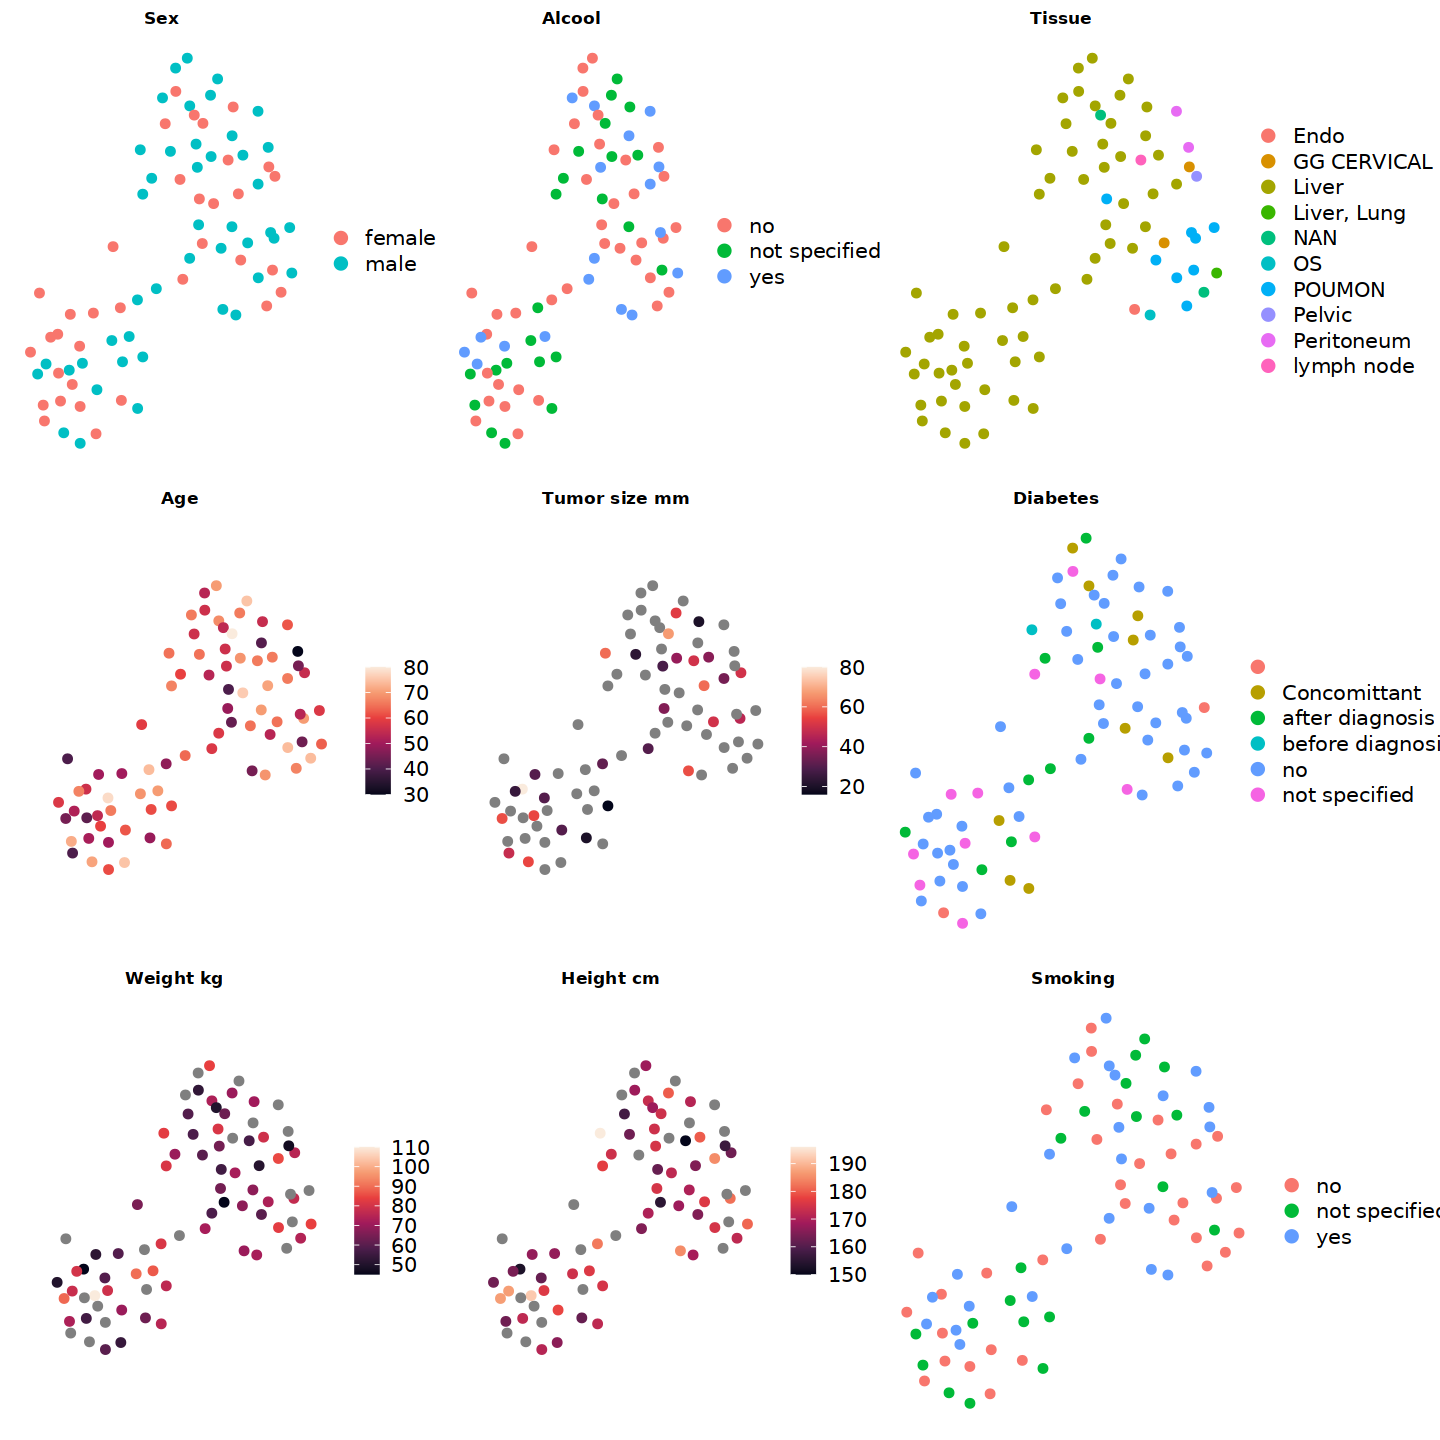

In [23]:
p1 <- cat_umap(seurat_obj,"Sex","Sex",'right')
p2 <- cat_umap(seurat_obj,"Alcool","Alcool",'right')
p3 <- cat_umap(seurat_obj,"Biopsie_tissue","Tissue",'right')
p4 <- num_umap(seurat_obj,"Age","Age",'right')
p5 <- num_umap(seurat_obj,"Tumor_dim_mm","Tumor size mm",'right')
p6 <- cat_umap(seurat_obj,"Diabetes","Diabetes",'right')

p9 <- cat_umap(seurat_obj,"Smoking","Smoking",'right')

p7 <- num_umap(seurat_obj,"Weight","Weight kg",'right')
p8 <- num_umap(seurat_obj,"Height_cm","Height cm",'right')


library(patchwork)
options(repr.plot.width=12, repr.plot.height=12)
grid.arrange(
  p1, p2, p3, 
  p4, p5, p6, 
  p7, p8, p9,
  layout_matrix = rbind(c(1, 2, 3),
                        c(4, 5, 6),
                        c(7, 8, 9)),
  widths = c(1, 1, 1.3),  # Relative widths of the columns
  heights = c(1, 1, 1)  # Relative heights of the rows
)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


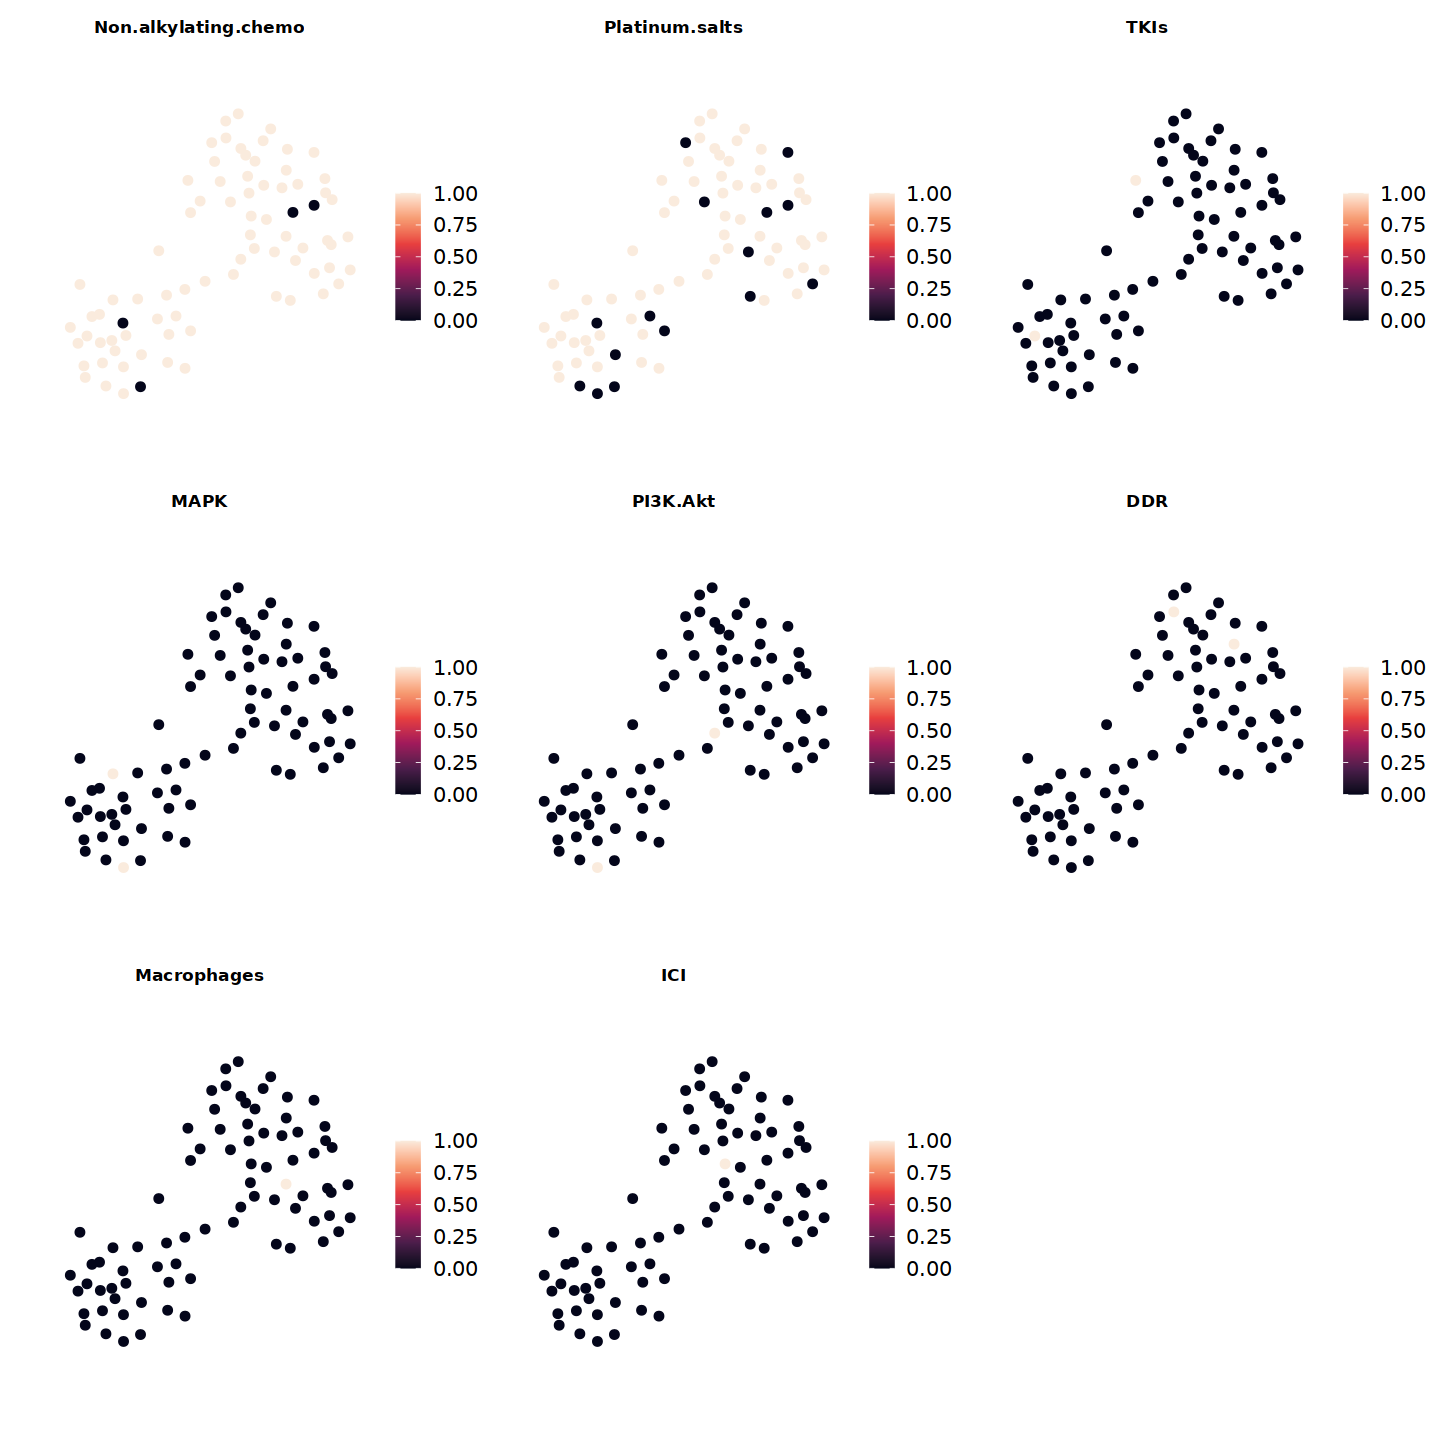

In [24]:
treatment_features  <- c("Non.alkylating.chemo", "Platinum.salts", "TKIs", "MAPK", "PI3K.Akt", "DDR", "Macrophages", "ICI")
p2 <- combined_umaps(seurat_obj,treatment_features)
print(p2)

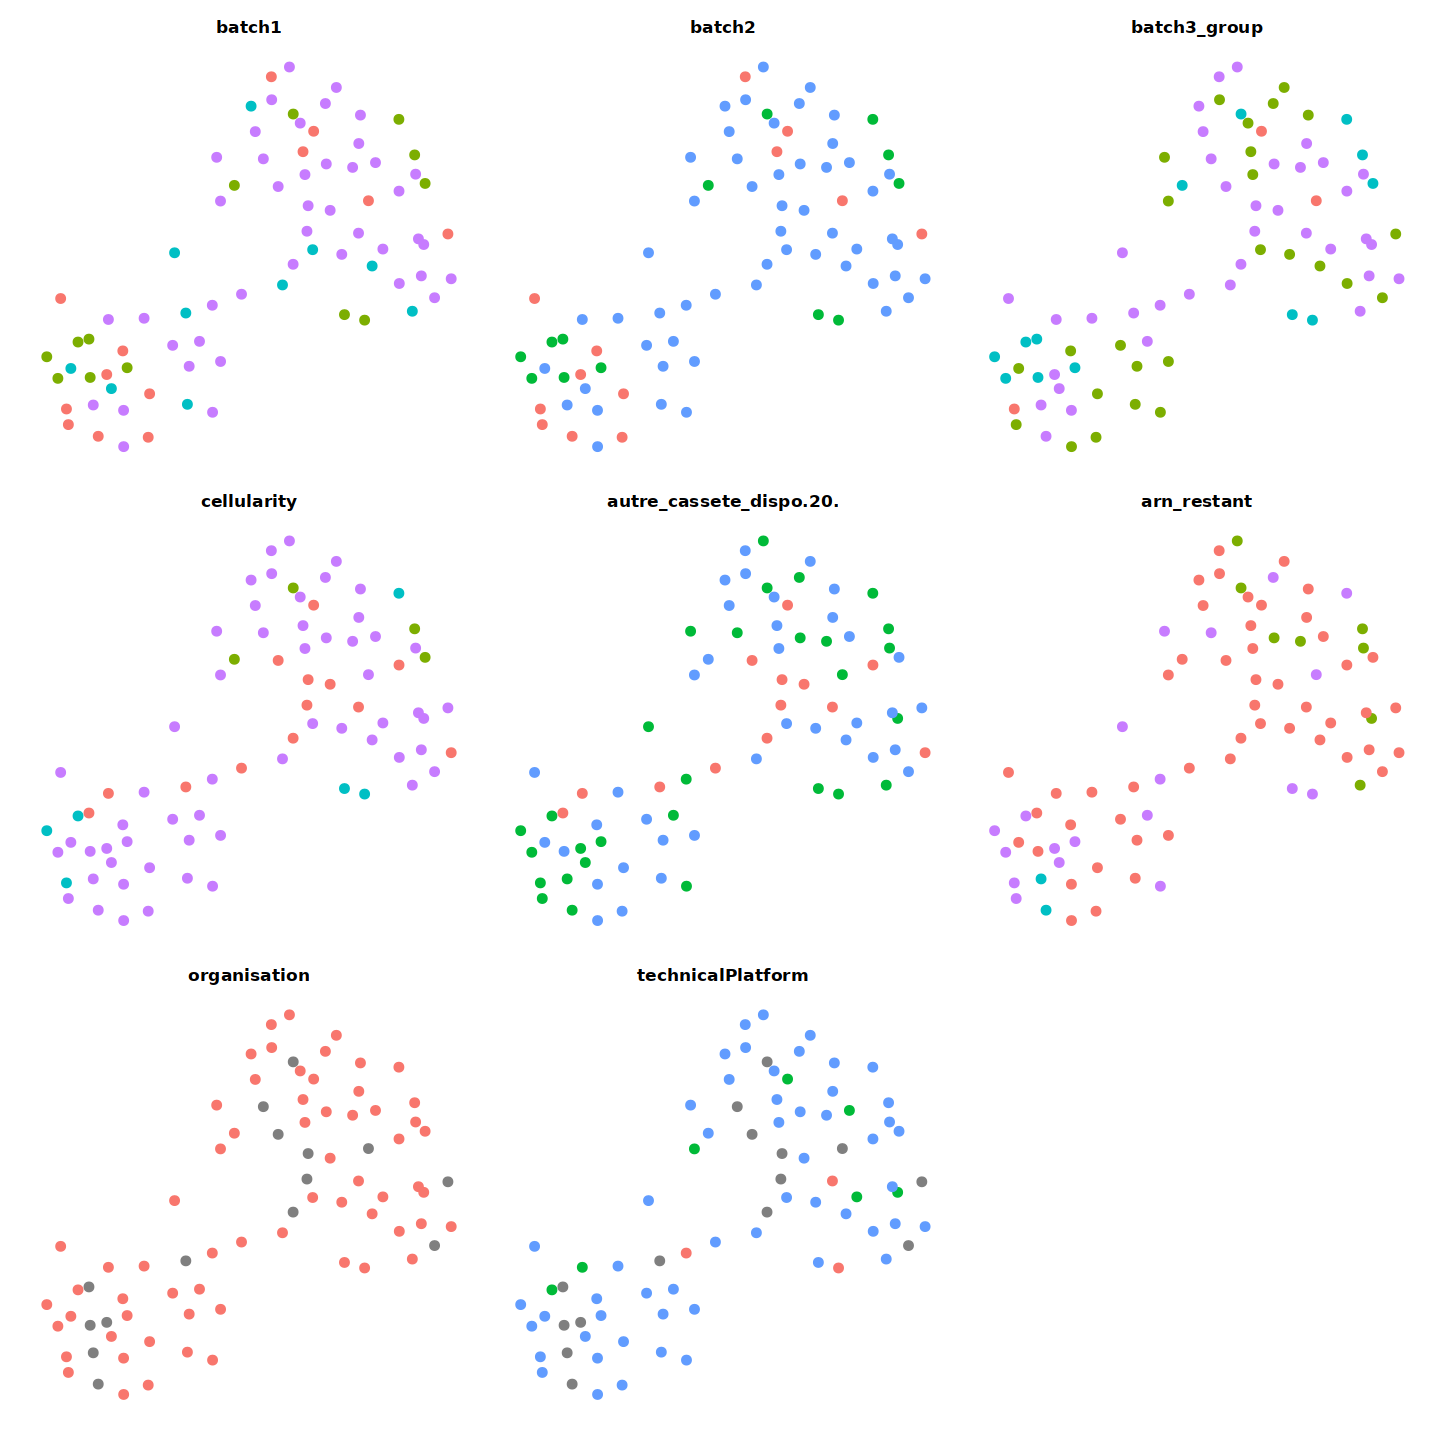

In [25]:
technical_features  <- c( "batch1", "batch2",  "batch3_group", "cellularity", "autre_cassete_dispo.20.", "arn_restant","organisation", "technicalPlatform")
p3 <-combined_umaps(seurat_obj,technical_features)
print(p3)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


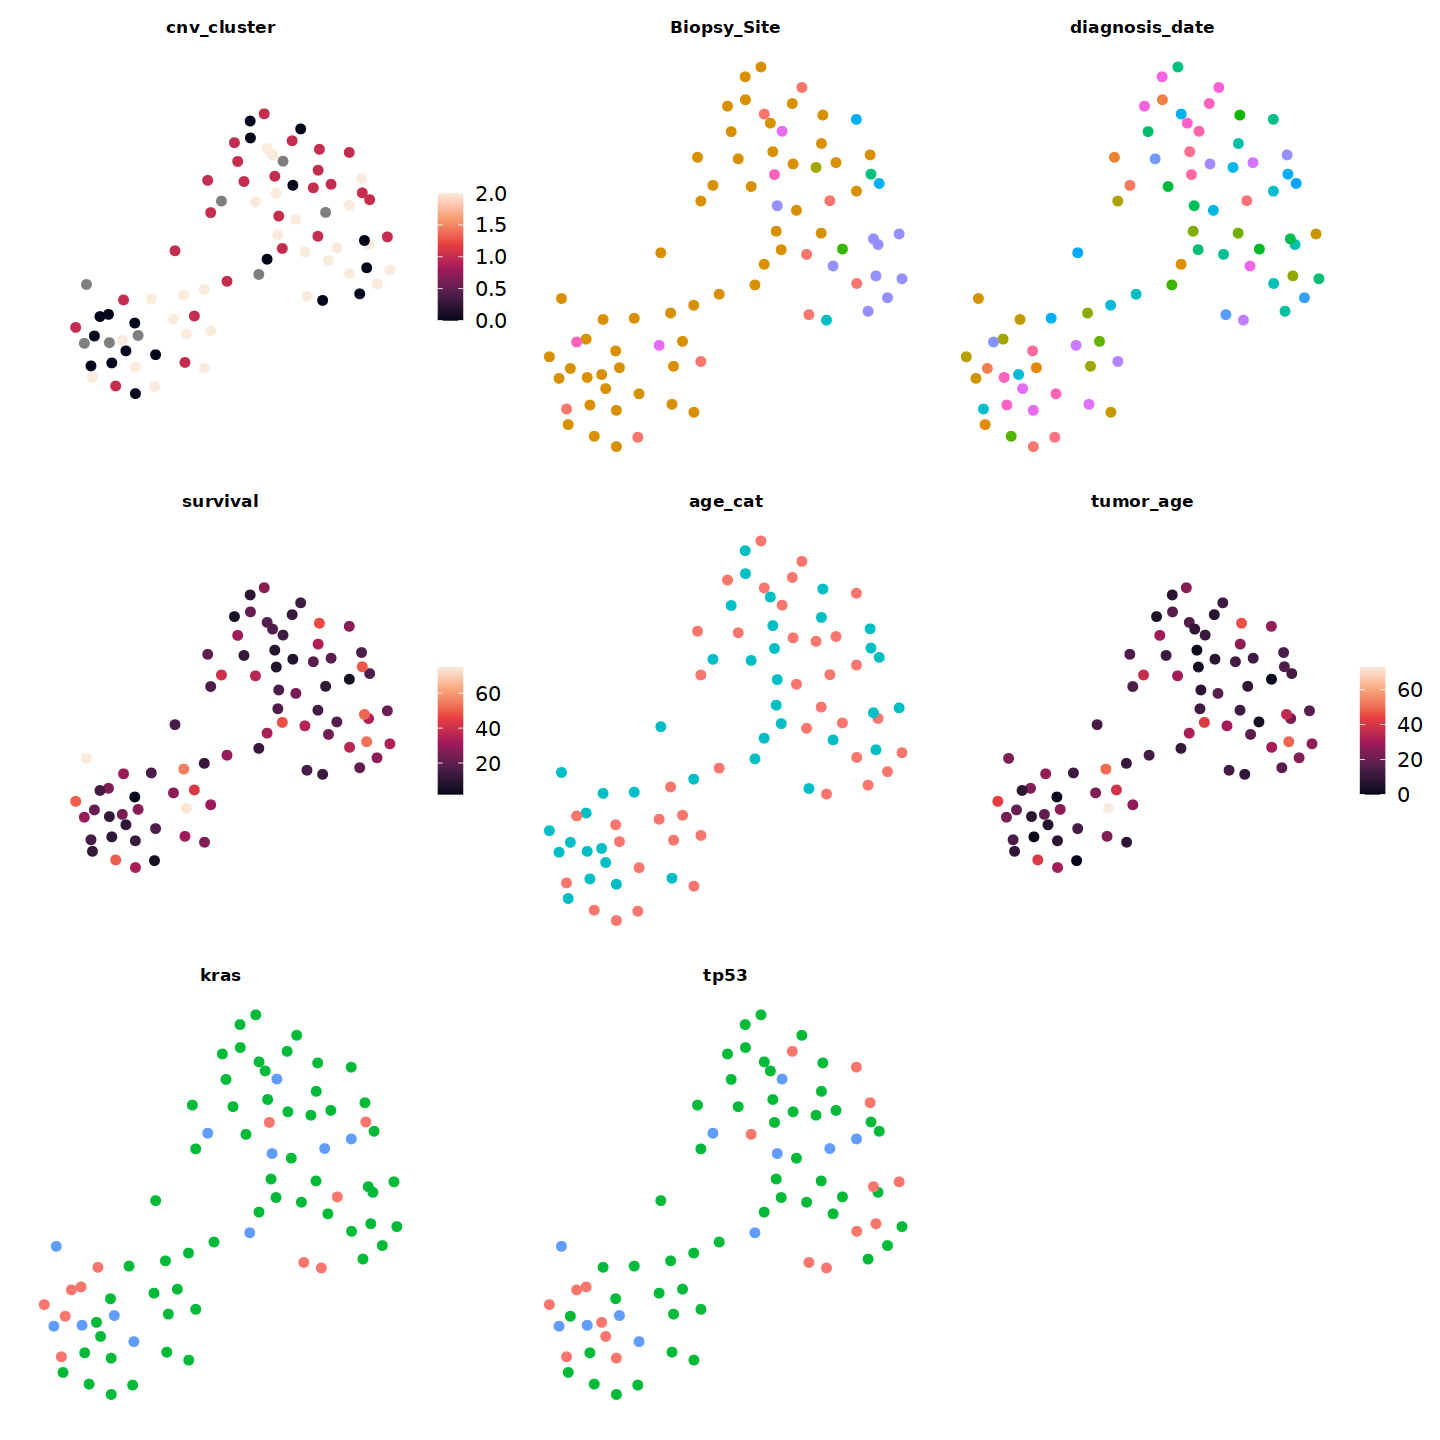

In [26]:
other_features <- c("cnv_cluster", "Biopsy_Site", "diagnosis_date", "survival", "age_cat", "tumor_age", "kras", "tp53")
p4 <- combined_umaps(seurat_obj,other_features)
print(p4)

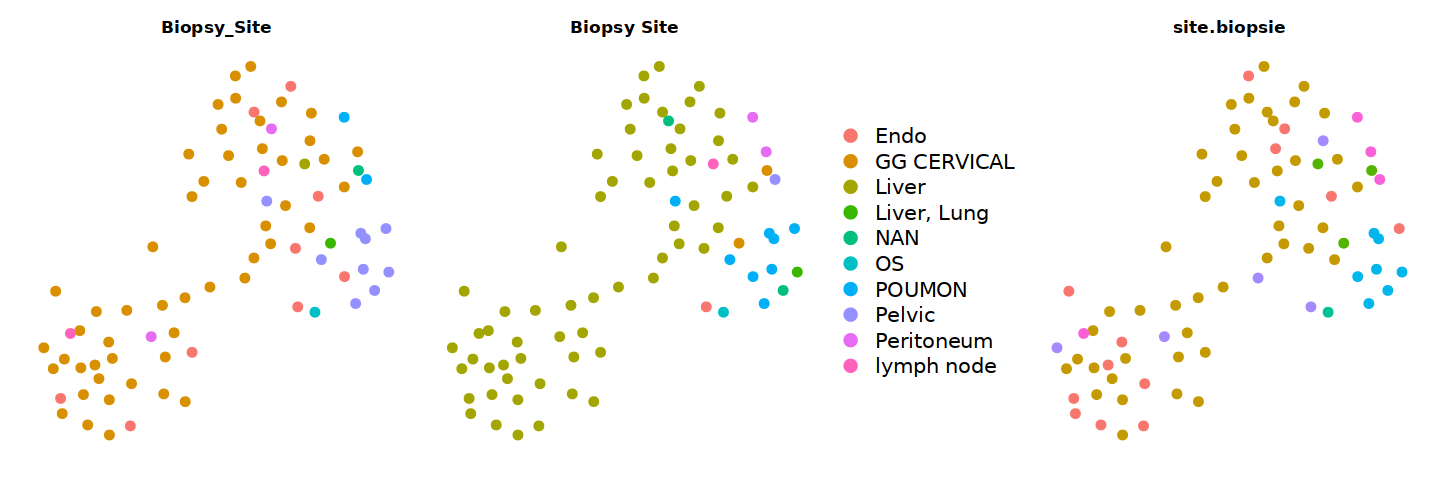

In [27]:
options(repr.plot.width=12, repr.plot.height=4)
p <- combined_umaps(seurat_obj,c('Biopsy_Site','Biopsie_tissue','site.biopsie'))
print(p)

In [28]:
calculate_cramers_v <- function(df, cat_col, group_col) {                                                                                                     
        # Create contingency table                                                                                                                            
        df[[cat_col]][is.na(df[[cat_col]])] <- "unknown"                                                                                                      
        cont_table <- table(df[[cat_col]], df[[group_col]])                                                                                                   
                                                                                                                                                              
        # Perform chi-square test                                                                                                                             
        chi_sq_test <- chisq.test(cont_table)                                                                                                                 
                                                                                                                                                              
        # Calculate Cramér's V                                                                                                                                
        n <- sum(cont_table)                                                                                                                                  
        min_dim <- min(nrow(cont_table) - 1, ncol(cont_table) - 1)                                                                                            
        cramers_v <- sqrt(chi_sq_test$statistic / (n * min_dim))                                                                                              
                                                                                                                                                              
        return(cramers_v)                                                                                                                                     
}                                                                                                                                                             
# Identify categorical columns (factors or characters)                                                                                                        
categorical_cols <- sapply(clinical, function(x) is.factor(x) | is.character(x))                                                                              
categorical_col_names <- names(clinical)[categorical_cols]                                                                                                    
#print(categorical_col_names)                                                                                                                                 
#cat_columns <- c("kras", "tp53")                                                                                                                             
results <- sapply(categorical_col_names, function(col) calculate_cramers_v(clinical, col, "Group"))                                                           
                                                                                                                                                              
cramer_res <- data.frame(                                                                                                                                     
                        Category = categorical_col_names,                                                                                                     
                        Cramers_V = results,                                                                                                                  
                        row.names = NULL                                                                                                                      
                        )                                                                                                                                     
kable(cramer_res[order(cramer_res$Cramers_V,decreasing = T),])



|   |Category                | Cramers_V|
|:--|:-----------------------|---------:|
|16 |scRNA                   |       Inf|
|1  |inclusion               | 1.0000000|
|11 |Diagnosis_Date          | 0.9866379|
|39 |Group                   | 0.9734543|
|2  |Tumor_Sample_Barcode    | 0.9454191|
|12 |Biopsie_Date            | 0.9454191|
|30 |batch3                  | 0.6753914|
|19 |Biopsie_tissue          | 0.4797653|
|17 |Diagnosis               | 0.4449999|
|22 |arn_restant             | 0.4118187|
|33 |Biopsy_Site             | 0.4050565|
|25 |site.biopsie            | 0.3784299|
|27 |meta.site.histo         | 0.3446614|
|10 |Diabetes                | 0.2783237|
|23 |batch1                  | 0.2703423|
|3  |Panel                   | 0.2665621|
|24 |batch2                  | 0.2281675|
|44 |KMT2D                   | 0.2199475|
|20 |cellularity             | 0.2126734|
|29 |biopsie                 | 0.2067265|
|26 |Meta                    | 0.2028688|
|28 |Primitif                | 0

In [29]:
clinical <- assign_cluster(clinical,treatments)
clinical <- clinical[!is.na(clinical$ICI),]
names(clinical)[names(clinical)=="cluster"] <- "Treatment_Category"

# Survival

[1] "Log-rank test p-value: 0.276"


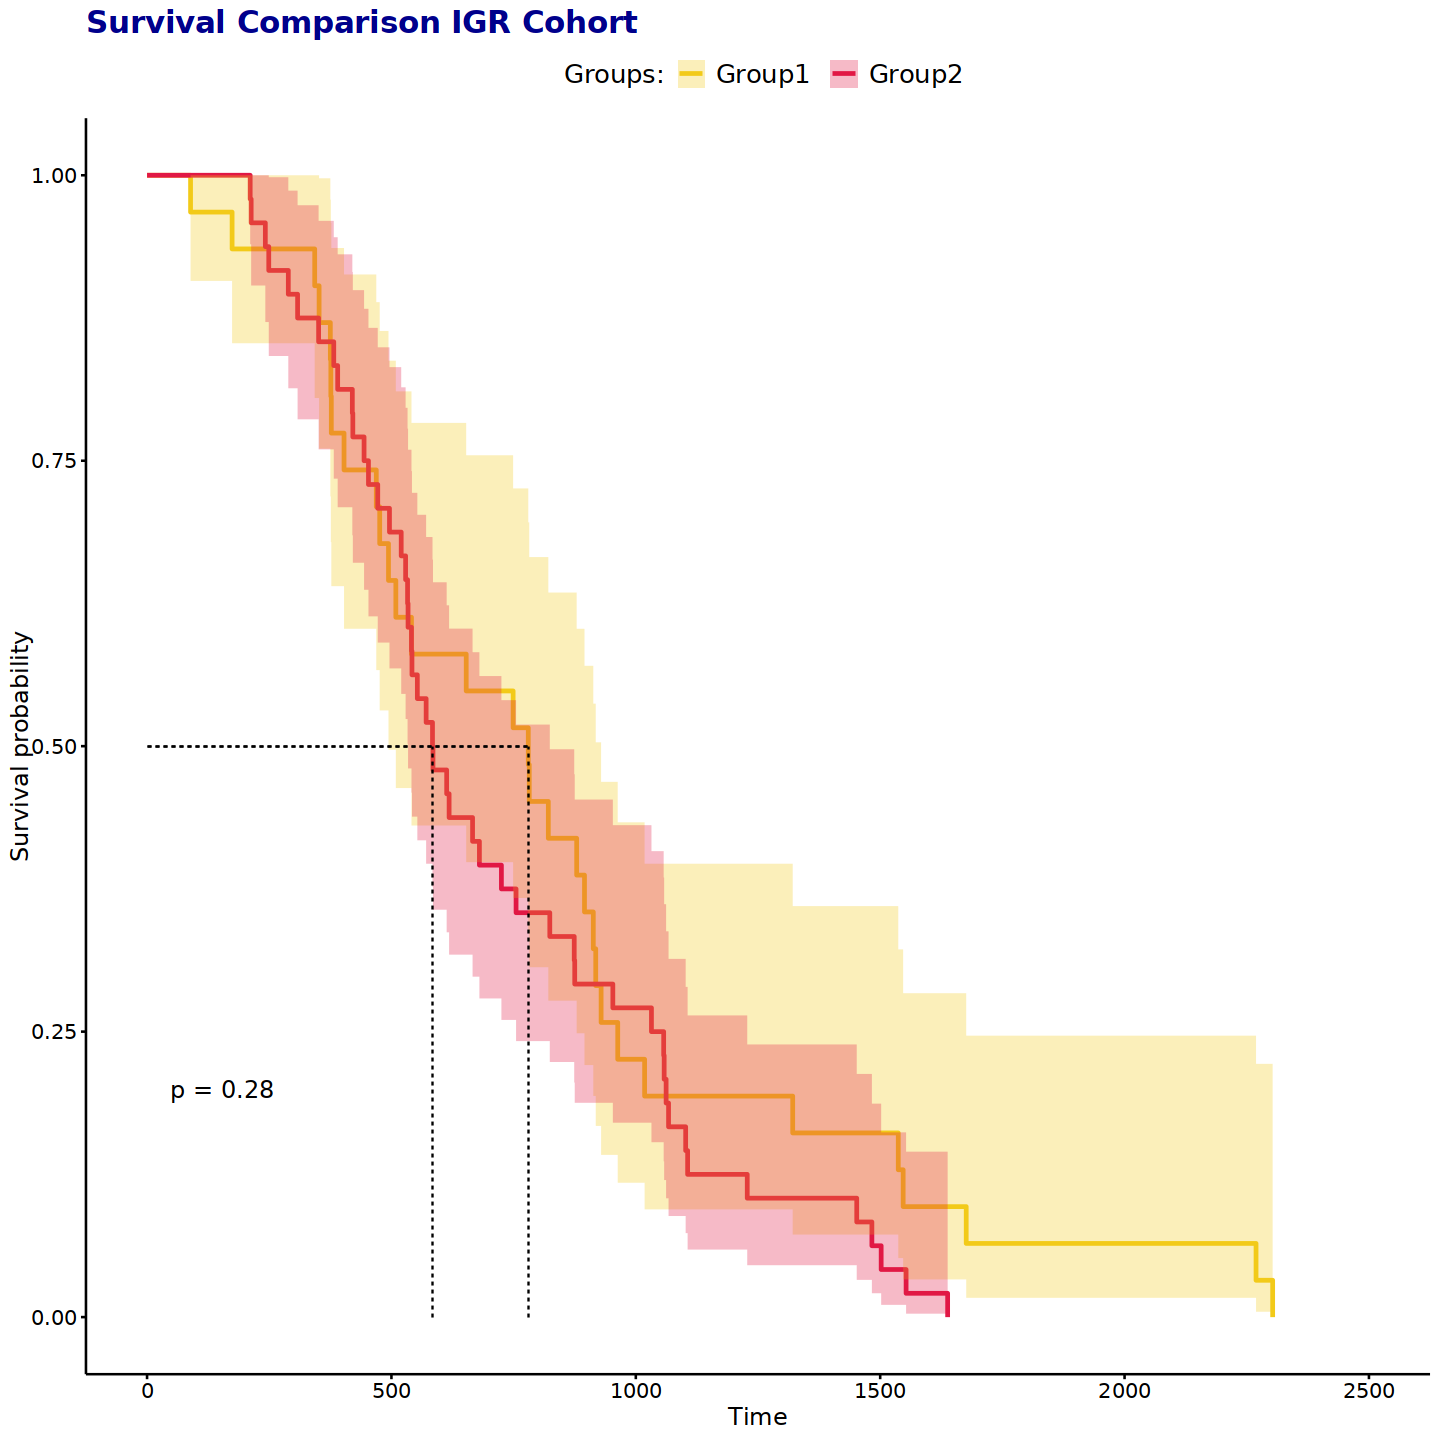

In [78]:
library(survival)
library(survminer)

clinical$status <- ifelse(clinical$Is_dead == 'Oui',0,1)

surv_object <- Surv(time = clinical$survival, 
                    event = clinical$status)

# Fit survival curves
fit <- survfit(surv_object ~ Group, data = clinical)

# Statistical tests
# Log-rank test
log_rank <- survdiff(surv_object ~ Group, data = clinical)
p_value <- 1 - pchisq(log_rank$chisq, df = 1)

# Create Kaplan-Meier plot
km_plot <- ggsurvplot(
  fit, title = "Survival Comparison IGR Cohort",
  data = clinical,
  pval = TRUE,           # Add p-value to the plot
  conf.int = TRUE,       # Add confidence intervals
  risk.table = F,     # Add risk table
  risk.table.height = 0.25,
  xlab = "Time",
  ylab = "Survival probability",
  palette = c(group1_color,group2_color),
  legend.title = "Groups:  ",
  legend.labs = c("Group1   ", "Group2"),
  surv.median.line = "hv" ,
  font.main = c(18, "bold", "darkblue"),
  font.x = c(14, "bold.italic"),
  font.y = c(14, "bold.italic"),
  font.tickslab = c(12, "plain"),
  font.legend = c(15, "plain")
  # Add median survival lines
)

# Print statistical summary
# print(summary(fit))
print(paste("Log-rank test p-value:", format.pval(p_value, digits = 3)))

options(repr.plot.width=12, repr.plot.height=12)
# Display the plot
print(km_plot)